# Supervised and Unsupervised Machine Learning for Colour Naming: Evaluating Performance and Data Processing Techniques

## Author: Anna Beattie
### github.com/raccoonhands

*This notebook contains all the code for the methods laid out in the titular study. Please read the following instructions on how to navigate and use this notebook.*

----------
IMPORTANT: This notebook MUST be run in Google Colab to avoid issues with library dependencies, unless you have the exact same conda set up and packages installed.

------------
Some of these models take hours to execute their LOOCV. It is recommended to **not** "restart > run all" and risk losing the outputs.

In order to experiment with the generalisation and visualisation functions at the end of this notebook, please run in the following order:
1. Imports
2. Data Cleaning & Preprocessing
3. Functions for Training and Evaluating All Models
4. Inside Supervised Learners run the sub-section called Refining the Choice of Data.
5. The functions for loading and saving the best performing models can be found in Load and Save Models
6. The functions for generalising on outside data can be found in Generalisation Tests > Functions for Generalising and Visualising Data.
7. The functions which were used to generate miscellaneous visualisations for the report are in Miscellaneous Visualisations.

As this is a large notebook, the choice was made to keep major functions at the top of their respective sections so they may be looked up easier than having them all right at the start of the notebook.

GITHUB VERSION: If you are reading this, you will not have access to the following files:


*   'xkcd_data': The file containing tab-delimited colour data for the generalisation tests.


*   'CN_Br_Am_English_Mylonas_2017.xlsx': The file containg the Colour Naming data.

*   'colour_naming_data.csv': A file containing a reduced set of the Colour Naming data

*   'misspelled_correct.csv': A file used in cleaning which contains mispellings and corrections for colour names. (Made by Akvile)

If you are accessing this notebook via Google Drive, there will probably be the images generated by the generalisation tests as well as a couple of saved NNs.



### Finally:

Efforts have been made to keep this document organised and readable, however for the most part it is a rough code artefact. Instead of full paragraphs, most information will be brief sentences in text boxes or comments in the code cells. A full explanation of the methods can be found in the corresponding report PDF.

# Imports
Must be run before anything else.

In [1]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=f7bb6aa7bfd16b45c3da271438bd98944eb995eaf467f1f908a15052888edd35
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [2]:
pip install scikeras[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 718.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling sci

In [3]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 5.0 MB/s eta 0:00:00


In [4]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=ec460a19c80430b5d7d4e6fbea144b8dcf810493a178039408c256f2728f91e7
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [5]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.0 MB/s eta 0:00:00


In [6]:
# data pre-processing
import numpy as np
import pandas as pd
from autocorrect import Speller
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier # might not be used
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import NearestNeighbors

# supervised classical models
import sklearn
from scipy.spatial.distance import euclidean
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# neural networks
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import BatchNormalization

# unsupervised models
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from minisom import MiniSom
from scipy.spatial.distance import cdist


# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import skimage
from skimage.color import rgb2luv, luv2rgb
from ast import Raise

# might need
# from scipy import stats
# import math

# training & validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from itertools import product



import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [12]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.0 MB/s eta 0:00:00


# Data Cleaning & Preprocessing

### Cleaning

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Import the data into a DataFrame
colname_df = pd.read_excel("/content/drive/MyDrive/dissertation/CN_Br_Am_English_Mylonas_2017.xlsx", skiprows=3)
colname_df.head()

,colorData_id,user_id,color_id,color_name,response_time,red,green,blue
0,27497,1375,582,'gray',16545,182,172,182
1,44568,2230,1094,'eighties_lipstick_pink',16231,239,2,105
2,21292,1065,640,'NaN',10249,147,153,99
3,21300,1065,577,'NaN',3579,165,180,154
4,74180,3711,588,'NaN',29056,204,237,221


In [16]:
colname_df.isna().sum()

,0
colorData_id,0
user_id,0
color_id,0
color_name,0
response_time,0
red,0
green,0
blue,0


The 'NaN' values are strings, so isna() did not show up the missing values.

In [17]:
print(colname_df['color_name'][3])

'NaN'


In [18]:
# British spelling
colname_df = colname_df.rename(columns={'color_name': 'colour_name'})

#### first attempt at cleaning

In [19]:
# Akvile's code for cleaning the colour naming data
# Must have access to mispelled_correct.csv

def correct_spelling(word, spelling_dict):
    """ Corrects the spelling of a word based on a provided dictionary. """
    return spelling_dict.get(word, word)

def clean_data(data, spelling_dict):
    """ Cleans the color names in the DataFrame by applying various string operations. """
    data = data.copy()
    data['colour_name'] = (data['colour_name'].str.lower()
                    .str.strip()
                    .replace('gray', 'grey', regex=True)
                    .replace(r'\s{2,}', ' ', regex=True) # moved to this part of function before spaces are replaced with underscores (From Anna)
                    .replace('[^\w\s-]', '', regex=True)  # Remove punctuation
                    .replace('[-\s/]+', '_', regex=True)  # Replace spaces, -, / with _
                    .replace(r'[!?\.",+/|]#+$', '', regex=True)  # Remove trailing punctuation

                    .replace(r'\b\w\b', '', regex=True)  # Remove single characters
                    # single characters may tell us what the word was trying to be when spell checking, like "p ink"
                    # so if you're going to use a spellchecker library, try leaving this out and see if it helps (From Anna)

                    .replace(r'\d+', '', regex=True)  # Remove digits
                    .apply(lambda x: correct_spelling(x, spelling_dict) if isinstance(x, str) else x))  # Correct spelling

    # Further clean-up of known placeholders
    data['colour_name'] = (data['colour_name']
                    .replace(r'^\s*$', 'NaN', regex=True)  # Replace empty entries with NaN
                    .replace(r'\b(NaN|nan|unknown)\b', 'not_known', regex=True))  # Replace NaN/unknown with not_known

    # Remove entries with low frequency names
    word_counts = data['colour_name'].value_counts()
    data = data[data['colour_name'].isin(word_counts[word_counts > 1].index)]

    return data

In [20]:
# Create the spelling dictionary and correct the data
spelling_data = pd.read_csv('/content/drive/MyDrive/dissertation/misspelled_correct.csv', encoding='latin1')
spelling_data_dict = dict(zip(spelling_data['Mispelled'], spelling_data['Correct']))

data = clean_data(colname_df, spelling_data_dict)


In [21]:
data = data[data['colour_name'] != 'not_known'] # remove not known
print(len(data))
print(len(colname_df))
print(len(colname_df)-len(data))

19587
21320
1733


In [22]:
data.value_counts('colour_name') # can use this for autocorrect
# but will need to add spaces back in

,count
colour_name,
purple,1401
pink,1077
blue,926
green,835
brown,540
...,...
wood_green,2
yellow_beige,2
yellowish_brown,2


#### Second attempt at cleaning

I am using this autocorrect https://github.com/filyp/autocorrect

It will capitalise and use appropriate punctuation, so normalising should happen after the autocorrect. It allows for a word frequency dict to be passed to it so I will generate one from the data, just so it should be correcting stuff like "pnk" to "pink" and not "punk".

May need to try a pass without custom dict, with custom dict, and with/ without punctuation.

In [23]:
unknown_df = spelling_data[spelling_data['Correct'] == 'not_known'] # dataframe of nonsense responses
unknown_df.head()

,Mispelled,Correct,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,__,not_known,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,_am,not_known,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-,not_known,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,;,not_known,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,;ue,not_known,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
unknown_dict = dict(zip(unknown_df['Mispelled'], unknown_df['Correct'])) # dict of nonsense responses

Below is a second modification of Akvile's code to leave in single characters in case they help inform the autocorrect

In [25]:
# modifying akvile's code
def identify_unknown(word, unknown_dict):
    """ Changes nonsense responses to 'not_known' based on a dictionary. """
    return unknown_dict.get(word, word)


def clean_data2(data, unknown_dict):
    """ Cleans the color names in the DataFrame by applying various string operations. """
    data = data.copy()
    data['colour_name'] = (data['colour_name'].str.lower()
                    .str.strip()
                    .replace('gray', 'grey', regex=True)
                    .replace(r'\s{2,}', ' ', regex=True) # moved to this part of function before spaces are replaced with underscores
                    .replace('[^\w\s-]', '', regex=True)  # Remove punctuation
                    .replace('[-\s/]+', '_', regex=True)  # Replace spaces, -, / with _
                    .replace(r'[!?\.",+/|]#+$', '', regex=True)  # Remove trailing punctuation

                    #.replace(r'\b\w\b', '', regex=True)  # Remove single characters
                    # single characters may tell us what the word was trying to be when spell checking, like "p ink"
                    # so if you're going to use a spellchecker library, try leaving this out and see if it helps

                    .replace(r'\d+', '', regex=True)  # Remove digits
                    .apply(lambda x: identify_unknown(x, unknown_dict) if isinstance(x, str) else x))  # Identify nonsense responses as 'not_known'

    # Clean-up of known placeholders for NaN values
    data['colour_name'] = (data['colour_name']
                    .replace(r'^\s*$', 'NaN', regex=True)  # Replace empty entries with NaN

                    .replace(r'\b(NaN|nan|unknown)\b', 'not_known', regex=True))  # Replace NaN/unknown with not_known

    # Remove entries with low frequency names
    word_counts = data['colour_name'].value_counts()
    data = data[data['colour_name'].isin(word_counts[word_counts > 1].index)]

    return data


In [26]:
data2 = clean_data2(colname_df, unknown_dict)
data2.head()

,colorData_id,user_id,color_id,colour_name,response_time,red,green,blue
0,27497,1375,582,grey,16545,182,172,182
2,21292,1065,640,not_known,10249,147,153,99
3,21300,1065,577,not_known,3579,165,180,154
4,74180,3711,588,not_known,29056,204,237,221
5,80887,4046,614,not_known,4401,130,85,88


In [27]:
data2 = data2[data2['colour_name'] != 'not_known'] # remove not known
print(len(data2))
print(len(colname_df))
print(len(colname_df)-len(data2))

19578
21320
1742


Now I'll use the clean data from Akvile's code help the autocorrect to correct to colour terms rather than other words, by calculating average word frequency as a dict to pass to an autocorrect Speller.

The first try of making this dict I found this:

'dont': 0.0001100190699721285, 'know': 0.0001100190699721285

Which means there are still entries for "don't know". Dimitris has already analysed the distribution of "don't know" in his thesis and I don't need this phrase for the model training, so I'll drop the "don't know" entries.


In [28]:
data = data[data['colour_name'] != 'dont_know'] # remove "dont know"
print(len(data))
print(len(colname_df))
print(len(colname_df)-len(data))

19584
21320
1736


I also found the following:

'terra': 0.00018340547281930892, 'cotta': 0.00018340547281930892

the presence of "med", "medium" and "mid"

'ref': 7.336218912772357e-05 is almost definitely a mispelling of "red" unless it comes before "blue", as in RAF Blue

'petrel': 7.336218912772357e-05 almost definitely "petrol"

'bubble': 0.0005502164184579268, 'gum': 0.0005502164184579268, should be "bubblegum"

what is "bura" ?

In [29]:
# Find instances of "ref" using str.contains with regex=True
matches_ref = data['colour_name'].str.contains(r'\bref\b|\bref_\w+|\w+_ref\b', regex=True)

# Filter the DataFrame to show rows where "ref" matches
df_ref = data[matches_ref]

print(df_ref)

      colorData_id  user_id  color_id colour_name  response_time  red  green  \
8580         12806      641      1067         ref           2075  197      0   
8581         66662     3335       789         ref           4165   96     23   

      blue  
8580    22  
8581     0  


"ref" appears alone and in cases where red is the highest RGB value, so we can safely assume it to be red.

In [30]:
# Replace mispellings
data['colour_name'] = data['colour_name'].str.replace(r'\bbubble_gum\b', 'bubblegum', regex=True)
data['colour_name'] = data['colour_name'].str.replace(r'\bterra_cotta\b', 'terracotta', regex=True)
data['colour_name'] = data['colour_name'].str.replace(r'\bref\b', 'red', regex=True)

<ipython-input-30-880dfc37a6c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['colour_name'] = data['colour_name'].str.replace(r'\bbubble_gum\b', 'bubblegum', regex=True)
<ipython-input-30-880dfc37a6c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['colour_name'] = data['colour_name'].str.replace(r'\bterra_cotta\b', 'terracotta', regex=True)
<ipython-input-30-880dfc37a6c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [31]:
# Find instances of "bura" using str.contains with regex=True
matches_bura = data['colour_name'].str.contains(r'\bbura\b|\bbura_\w+|\w+_bura\b', regex=True)

# Filter the DataFrame to show rows where "ref" matches
df_bura = data[matches_bura]

print(df_bura)

      colorData_id  user_id  color_id colour_name  response_time  red  green  \
1624         32650     1634       634        bura           6106  181    138   
1625         32654     1634       712        bura           4329  171    104   
1626         32665     1634       565        bura           6922  138    119   

      blue  
1624   139  
1625   101  
1626   104  


I have no idea what bura is so I'll just leave it.

I am also leaving medium, mid, and med as is.

Creating the dict now:

In [32]:
# list to store all words
words = []
for phrase in data['colour_name']:
    words.extend(phrase.split('_'))

# word frequency using defaultdict
word_count = defaultdict(int)
for word in words:
    word_count[word] += 1

# avg frequency
total_words = len(words)
word_frequency_dict = {word: count / total_words for word, count in word_count.items()}

print(word_frequency_dict)

{'grey': 0.029088107989142395, 'acid': 0.00033012985107475605, 'green': 0.09449049959650796, 'yellow': 0.03106888709559093, 'adobe': 0.00022008656738317073, 'aqua': 0.005868975130217885, 'amber': 0.0006602597021495121, 'antique': 7.336218912772357e-05, 'white': 0.009940576626806544, 'apple': 0.0007336218912772357, 'apricot': 0.0006602597021495121, 'blue': 0.09460054288019955, 'marine': 0.0005868975130217885, 'mint': 0.0049152666715574795, 'aquamarine': 0.0014672437825544713, 'army': 0.0005868975130217885, 'aubergine': 0.0017606925390653658, 'auburn': 7.336218912772357e-05, 'avocado': 0.00018340547281930892, 'azure': 0.0007336218912772357, 'baby': 0.002897806470545081, 'pink': 0.0743892597755117, 'banana': 7.336218912772357e-05, 'barbie': 0.0004034920402024796, 'beige': 0.004401731347663414, 'berry': 0.00014672437825544713, 'black': 0.009610446775731788, 'blood': 0.0004034920402024796, 'orange': 0.025786809478394835, 'red': 0.022302105494827966, 'purple': 0.08029491600029345, 'violet': 

Initialising the speller and using the dict to influence the spelling choices:

In [33]:
# initialise
spell = Speller()
# Update the spell.nlp_data with custom dict
spell.nlp_data.update(word_frequency_dict)

In [34]:
def autocorrect(entry):
    corrected_entry = spell(entry)
    if corrected_entry != entry:
        print(f"{entry} was corrected to {corrected_entry}")
    return corrected_entry

In [35]:
clean_data = data2.copy()
clean_data['colour_name'] = clean_data['colour_name'].apply(autocorrect)
clean_data.head()

seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam was corrected to seafood
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to seafood_green
seafoam_green was corrected to 

,colorData_id,user_id,color_id,colour_name,response_time,red,green,blue
0,27497,1375,582,grey,16545,182,172,182
6,61452,3075,1029,acid_green,17878,110,227,99
7,59732,2989,835,acid_yellow,10471,174,147,35
8,38181,1910,805,adobe,8776,151,76,38
9,45868,2295,597,adobe,3658,71,42,17


In [36]:
matches_punk = data2['colour_name'].str.contains(r'\bpunk\b|\bpunk_\w+|\w+_punk\b', regex=True)

# Filter the DataFrame to show rows where "ref" matches
df_punk = clean_data[matches_punk]

print(df_punk)

Empty DataFrame
Columns: [colorData_id, user_id, color_id, colour_name, response_time, red, green, blue]
Index: []


It didn't correct any words other than seafoam to seafood (which is obviously not desirable).

I will just use data2 with the spellings I found corrected.

In [37]:
# Replace mispellings
data2['colour_name'] = data2['colour_name'].str.replace(r'\bbubble_gum\b', 'bubblegum', regex=True)
data2['colour_name'] = data2['colour_name'].str.replace(r'\bterra_cotta\b', 'terracotta', regex=True)
data2['colour_name'] = data2['colour_name'].str.replace(r'\bref\b', 'red', regex=True)
# remove "dont know"
data2 = data2[data2['colour_name'] != 'dont_know']

In [38]:
clean_data = data2.copy()
len(clean_data)

19575

In [39]:
clean_data = clean_data.rename(columns={'color_id': 'colour_id'})
clean_data.head()

,colorData_id,user_id,colour_id,colour_name,response_time,red,green,blue
0,27497,1375,582,grey,16545,182,172,182
6,61452,3075,1029,acid_green,17878,110,227,99
7,59732,2989,835,acid_yellow,10471,174,147,35
8,38181,1910,805,adobe,8776,151,76,38
9,45868,2295,597,adobe,3658,71,42,17


## Modal Colour Name Calculation & Class Selection

In [40]:
# to ignore the warnings about modifying a slice of the data
pd.options.mode.chained_assignment = None

In [41]:
# Counting unique entries in 'colour_name'
unique_count = clean_data['colour_name'].nunique()

print(f"Number of unique entries in 'colour_name': {unique_count}")

Number of unique entries in 'colour_name': 891


In [42]:
# Counting unique entries in 'colour_name'
unique_count = clean_data['colour_id'].nunique()

print(f"Number of unique entries in 'color_id': {unique_count}")

Number of unique entries in 'color_id': 600


There are 891 colour names for 600 colour samples. I want to reduce the number of colour names by finding the minimum number of unique colour names that can entirely cover all 600 colour samples. To do this I will be calculating the modal colour name for each sample, and in the case of tie breaks finding the modal colour name across the entire dataset.

First, I want to make sure that there are an equal number of each colour sample, so that my modal calculations are not skewed.

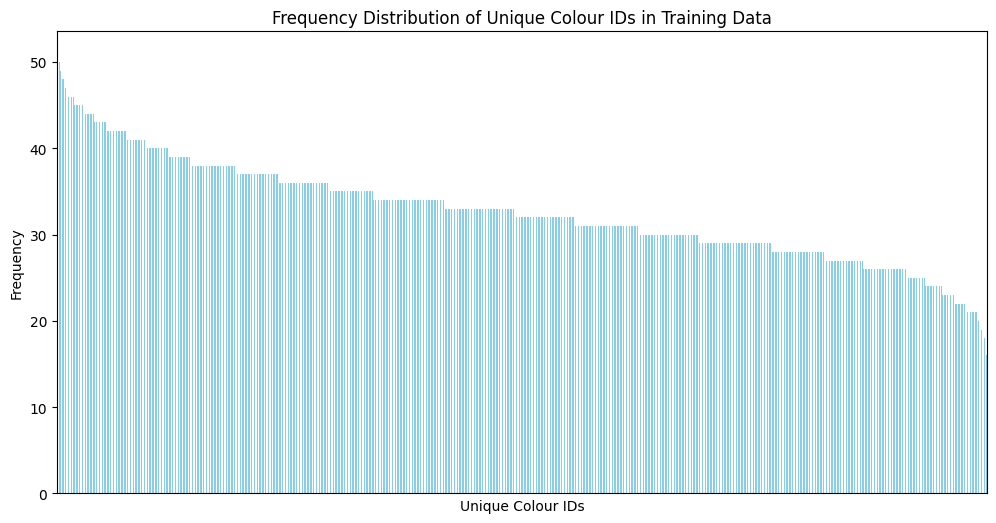

In [43]:
# Count the frequency of each colour_id
colour_id_counts = clean_data['colour_id'].value_counts()

# Plot the frequency of each colour_id
plt.figure(figsize=(12, 6))
colour_id_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency Distribution of Unique Colour IDs in Training Data')
plt.xlabel('Unique Colour IDs')
plt.ylabel('Frequency')

# Remove the x-axis ticks (both labels and tick marks)
plt.xticks([])

plt.show()

In [44]:
# find the most frequent colour_id in clean_data
most_frequent_colour_id = clean_data['colour_id'].value_counts().idxmax()
# find the least frequent colour_id in clean_data
least_frequent_colour_id = clean_data['colour_id'].value_counts().idxmin()

most_frequent_colour_id_count = clean_data['colour_id'].value_counts().max()
least_frequent_colour_id_count = clean_data['colour_id'].value_counts().min()

print(f"The most frequent colour_id is {most_frequent_colour_id} with a frequency of {most_frequent_colour_id_count}.")
print(f"The least frequent colour_id is {least_frequent_colour_id} with a frequency of {least_frequent_colour_id_count}.")

The most frequent colour_id is 861 with a frequency of 51.
The least frequent colour_id is 600 with a frequency of 16.


There is an imbalance here which could indeed skew the modal colour name calculations. I will use Random Oversampling to balance the data whilst maintaining the proportions of colour names for each colour id.

In [45]:
# drop all columns except colour_id, colour_name, red, green and blue
clean_data = clean_data.drop(columns=['colorData_id', 'user_id', 'response_time'])
clean_data.head()

,colour_id,colour_name,red,green,blue
0,582,grey,182,172,182
6,1029,acid_green,110,227,99
7,835,acid_yellow,174,147,35
8,805,adobe,151,76,38
9,597,adobe,71,42,17


I am using colour_name and colour_id as my X and y.

In [46]:
# Prepare the features (which includes 'colour_name') and the target ('colour_id')
X = clean_data[['colour_name']]
y = clean_data['colour_id']

# Apply Random Oversampling to balance the 'colour_id'
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Map the resampled data back to its original form
clean_data_resampled = pd.DataFrame({
    'colour_id': y_res,
    'colour_name': X_res['colour_name']
})

# Now, merge the RGB values back into the resampled dataframe
# Since each 'colour_id' has a unique RGB value, we can use the original df to merge this information
rgb_values = clean_data[['colour_id', 'red', 'green', 'blue']].drop_duplicates()
clean_data_resampled = pd.merge(clean_data_resampled, rgb_values, on='colour_id', how='left')

# Find the most frequent and least frequent 'colour_id' in clean_data_resampled
most_frequent_colour_id = clean_data_resampled['colour_id'].value_counts().idxmax()
least_frequent_colour_id = clean_data_resampled['colour_id'].value_counts().idxmin()

most_frequent_colour_id_count = clean_data_resampled['colour_id'].value_counts().max()
least_frequent_colour_id_count = clean_data_resampled['colour_id'].value_counts().min()

print(f"The most frequent colour_id is {most_frequent_colour_id} with a frequency of {most_frequent_colour_id_count}.")
print(f"The least frequent colour_id is {least_frequent_colour_id} with a frequency of {least_frequent_colour_id_count}.")


The most frequent colour_id is 907 with a frequency of 51.
The least frequent colour_id is 907 with a frequency of 51.


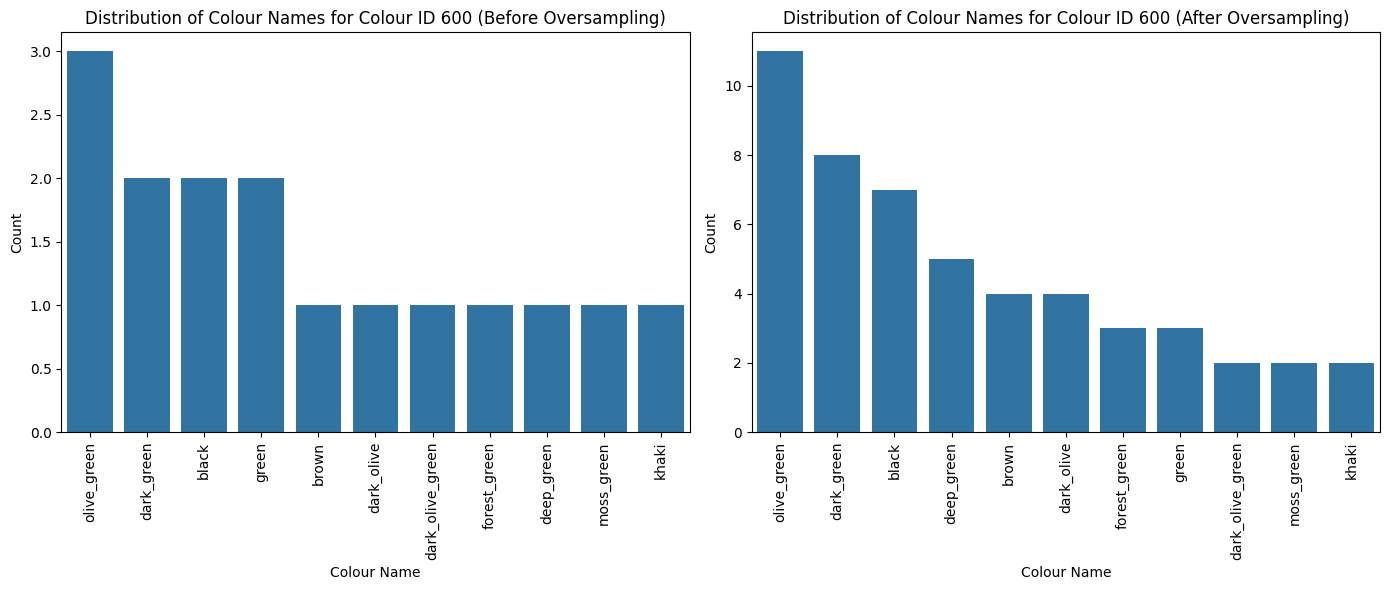

In [47]:
# 'colour_id' 600 before oversampling
subset_before = clean_data[clean_data['colour_id'] == 600]

# 'colour_id' 600 after oversampling
subset_after = clean_data_resampled[clean_data_resampled['colour_id'] == 600]

# Plot the distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=subset_before, x='colour_name', order=subset_before['colour_name'].value_counts().index)
plt.title('Distribution of Colour Names for Colour ID 600 (Before Oversampling)')
plt.xticks(rotation=90)
plt.xlabel('Colour Name')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.countplot(data=subset_after, x='colour_name', order=subset_after['colour_name'].value_counts().index)
plt.title('Distribution of Colour Names for Colour ID 600 (After Oversampling)')
plt.xticks(rotation=90)
plt.xlabel('Colour Name')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [48]:
# Backup
og_clean_data = clean_data.copy()
clean_data = clean_data_resampled.copy()

The following code uses the color_id column to find the modal colour term for each colour ID. If there is a clear modal term, it is stored as a string. If the modal terms are tied, then they are stored as a list.

In [49]:
# Group by the color_id
grouped = clean_data.groupby('colour_id')

# Function to get modes of 'colour_name'
def get_modes(group):
    modes = group['colour_name'].mode().tolist()
    unique_modes = list(set(modes))
    return unique_modes if len(unique_modes) > 1 else unique_modes[0]

# Apply the function to each group
modal_colours = grouped.apply(get_modes).reset_index()
modal_colours.columns = ['colour_id', 'modal_colour_names']

# Drop duplicates to get unique color_id and RGB values
unique_rgb = clean_data.drop_duplicates(subset='colour_id')[['colour_id', 'red', 'green', 'blue']]

# Merge modal colours with unique RGB values
modal_df = pd.merge(modal_colours, unique_rgb, on='colour_id')

modal_df.head()

,colour_id,modal_colour_names,red,green,blue
0,533,black,0,0,0
1,534,black,28,28,28
2,535,black,49,49,49
3,536,grey,72,72,72
4,537,grey,97,97,97


In [50]:
modal_ties = modal_df[modal_df['modal_colour_names'].apply(lambda x: isinstance(x, list))]
modal_ties.head()

,colour_id,modal_colour_names,red,green,blue
11,544,"[dark_brown, brown]",45,21,25
29,562,"[grey, purple]",82,67,83
32,565,"[light_brown, brown]",138,119,104
56,589,"[sky_blue, light_green]",203,236,233
71,604,"[green, bottle_green]",3,56,51


In [51]:
# I already have the modal names in modal_df and the ones which have tied modal names in modal_ties
modal_df = modal_df[modal_df['modal_colour_names'].apply(lambda x: isinstance(x, str))]

# number of unique values in colour_id of modal_df:
print(modal_df['colour_id'].nunique())

# number of unique values in colour_id of modal_ties:
print(modal_ties['colour_id'].nunique())

570
30


Now I need to look at the colour ID and suggested names in modal_ties and see which name is the most frequent throughout the whole dataset.

In [52]:
def find_most_frequent_colour_name(colour_names):
    # Filter clean_data for the given colour_names
    subset = clean_data[clean_data['colour_name'].isin(colour_names)]

    # Find the most frequent colour name
    if not subset.empty:
        most_frequent = subset['colour_name'].value_counts().idxmax()
    else:
        most_frequent = None  # In case there's no matching colour_name

    return most_frequent

# Apply the function to each row in modal_ties
modal_ties_copy = modal_ties.copy()
modal_ties_copy['best_colour_name'] = modal_ties_copy['modal_colour_names'].apply(find_most_frequent_colour_name)

modal_ties_copy.head()


,colour_id,modal_colour_names,red,green,blue,best_colour_name
11,544,"[dark_brown, brown]",45,21,25,brown
29,562,"[grey, purple]",82,67,83,purple
32,565,"[light_brown, brown]",138,119,104,brown
56,589,"[sky_blue, light_green]",203,236,233,sky_blue
71,604,"[green, bottle_green]",3,56,51,green


In [53]:
# Count the number of lists in best_colour_name
num_lists = sum(isinstance(x, list) for x in modal_ties_copy['best_colour_name'])

# Display the result
print(f"Number of lists in best_colour_name: {num_lists}")

Number of lists in best_colour_name: 0


Since there are no lists left after doing that, there are no more tie-breakers needed.

In [54]:
modal_df.head()

,colour_id,modal_colour_names,red,green,blue
0,533,black,0,0,0
1,534,black,28,28,28
2,535,black,49,49,49
3,536,grey,72,72,72
4,537,grey,97,97,97


In [55]:
# Preparing dataframes for joining by unifying naming conventions
modal_df = modal_df.rename(columns={'color_id': 'colour_id'})
modal_df = modal_df.rename(columns={'modal_colour_names': 'colour_name'})
modal_ties_copy = modal_ties_copy.rename(columns={'color_id': 'colour_id'})
modal_ties_copy = modal_ties_copy.rename(columns={'best_colour_name': 'colour_name'})

modal_ties_copy = modal_ties_copy[['colour_id', 'colour_name', 'red', 'green', 'blue']]

In [56]:
modal_colour_names = pd.concat([modal_df, modal_ties_copy])
modal_colour_names.head()

,colour_id,colour_name,red,green,blue
0,533,black,0,0,0
1,534,black,28,28,28
2,535,black,49,49,49
3,536,grey,72,72,72
4,537,grey,97,97,97


In [57]:
colour_names = modal_colour_names['colour_name'].unique()
print(colour_names)
print(f"There are {len(colour_names)} unique colour names for {len(modal_colour_names)} colour samples.")

['black' 'grey' 'white' 'brown' 'khaki' 'grey_green' 'dark_green'
 'dark_teal' 'taupe' 'olive' 'green' 'blue' 'beige' 'light_blue' 'cream'
 'pale_green' 'maroon' 'olive_green' 'navy_blue' 'purple' 'dark_purple'
 'plum' 'burgundy' 'teal' 'turquoise' 'blue_grey' 'mauve' 'pink' 'tan'
 'lavender' 'peach' 'pale_yellow' 'aqua' 'light_grey' 'lilac' 'light_pink'
 'forest_green' 'dark_pink' 'light_brown' 'mustard' 'dark_yellow' 'yellow'
 'light_green' 'mint_green' 'sky_blue' 'cyan' 'red' 'navy' 'dark_blue'
 'rose' 'salmon' 'burnt_orange' 'orange' 'gold' 'periwinkle'
 'yellow_green' 'mint' 'chartreuse' 'indigo' 'lime_green' 'fuchsia'
 'light_purple' 'hot_pink' 'magenta' 'light_red' 'violet']
There are 66 unique colour names for 600 colour samples.


Six of the colours have been split by whether or not their monolexemic form has been used: Navy Blue and Navy, Lime Green and Lime, Olive Green and Olive. I will check which of these forms is the most commonly used and unify them.

In [58]:
# count the number of times each form appears in the data
lime_green_count = (clean_data['colour_name'] == 'lime_green').sum()
lime_count = (clean_data['colour_name'] == 'lime').sum()
navy_blue_count = (clean_data['colour_name'] == 'navy_blue').sum()
navy_count = (clean_data['colour_name'] == 'navy').sum()
olive_green_count = (clean_data['colour_name'] == 'olive_green').sum()
olive_count = (clean_data['colour_name'] == 'olive').sum()
mint_green_count = (clean_data['colour_name'] == 'mint_green').sum()
mint_count = (clean_data['colour_name'] == 'mint').sum()

print(f"Lime Green appears {lime_green_count} times.")
print(f"Lime appears {lime_count} times.")
print(f"Navy Blue appears {navy_blue_count} times.")
print(f"Navy appears {navy_count} times.")
print(f"Olive Green appears {olive_green_count} times.")
print(f"Olive appears {olive_count} times.")
print(f"Mint Green appears {mint_green_count} times.")
print(f"Mint appears {mint_count} times.")

Lime Green appears 203 times.
Lime appears 84 times.
Navy Blue appears 162 times.
Navy appears 104 times.
Olive Green appears 104 times.
Olive appears 186 times.
Mint Green appears 106 times.
Mint appears 63 times.


In [59]:
lime_green_count = (modal_colour_names['colour_name'] == 'lime_green').sum()
lime_count = (modal_colour_names['colour_name'] == 'lime').sum()
navy_blue_count = (modal_colour_names['colour_name'] == 'navy_blue').sum()
navy_count = (modal_colour_names['colour_name'] == 'navy').sum()
olive_green_count = (modal_colour_names['colour_name'] == 'olive_green').sum()
olive_count = (modal_colour_names['colour_name'] == 'olive').sum()
mint_green_count = (modal_colour_names['colour_name'] == 'mint_green').sum()
mint_count = (modal_colour_names['colour_name'] == 'mint').sum()

print(f"Lime Green appears {lime_green_count} times.")
print(f"Lime appears {lime_count} times.")
print(f"Navy Blue appears {navy_blue_count} times.")
print(f"Navy appears {navy_count} times.")
print(f"Olive Green appears {olive_green_count} times.")
print(f"Olive appears {olive_count} times.")
print(f"Mint Green appears {mint_green_count} times.")
print(f"Mint appears {mint_count} times.")

Lime Green appears 7 times.
Lime appears 0 times.
Navy Blue appears 5 times.
Navy appears 1 times.
Olive Green appears 2 times.
Olive appears 5 times.
Mint Green appears 1 times.
Mint appears 1 times.


I will unify all cases of lime to lime green, and navy to navy blue, and olive green to olive.

In [60]:
# change lime to lime_green
modal_colour_names.loc[modal_colour_names['colour_name'] == 'lime', 'colour_name'] = 'lime_green'

# change navy to navy_blue
modal_colour_names.loc[modal_colour_names['colour_name'] == 'navy', 'colour_name'] = 'navy_blue'

#change olive_green to olive
modal_colour_names.loc[modal_colour_names['colour_name'] == 'olive_green', 'colour_name'] = 'olive'

# Change mint to mint_green
modal_colour_names.loc[modal_colour_names['colour_name'] == 'mint', 'colour_name'] = 'mint_green'

lime_green_count = (modal_colour_names['colour_name'] == 'lime_green').sum()
lime_count = (modal_colour_names['colour_name'] == 'lime').sum()
navy_blue_count = (modal_colour_names['colour_name'] == 'navy_blue').sum()
navy_count = (modal_colour_names['colour_name'] == 'navy').sum()
olive_green_count = (modal_colour_names['colour_name'] == 'olive_green').sum()
olive_count = (modal_colour_names['colour_name'] == 'olive').sum()
mint_green_count = (modal_colour_names['colour_name'] == 'mint_green').sum()
mint_count = (modal_colour_names['colour_name'] == 'mint').sum()

print(f"Lime Green appears {lime_green_count} times.")
print(f"Lime appears {lime_count} times.")
print(f"Navy Blue appears {navy_blue_count} times.")
print(f"Navy appears {navy_count} times.")
print(f"Olive Green appears {olive_green_count} times.")
print(f"Olive appears {olive_count} times.")
print(f"Mint Green appears {mint_green_count} times.")
print(f"Mint appears {mint_count} times.")

Lime Green appears 7 times.
Lime appears 0 times.
Navy Blue appears 6 times.
Navy appears 0 times.
Olive Green appears 0 times.
Olive appears 7 times.
Mint Green appears 2 times.
Mint appears 0 times.


In [61]:
colour_names = modal_colour_names['colour_name'].unique()
print(colour_names)
print(f"There are {len(colour_names)} unique colour names for {len(clean_data)} colour samples.")

['black' 'grey' 'white' 'brown' 'khaki' 'grey_green' 'dark_green'
 'dark_teal' 'taupe' 'olive' 'green' 'blue' 'beige' 'light_blue' 'cream'
 'pale_green' 'maroon' 'navy_blue' 'purple' 'dark_purple' 'plum'
 'burgundy' 'teal' 'turquoise' 'blue_grey' 'mauve' 'pink' 'tan' 'lavender'
 'peach' 'pale_yellow' 'aqua' 'light_grey' 'lilac' 'light_pink'
 'forest_green' 'dark_pink' 'light_brown' 'mustard' 'dark_yellow' 'yellow'
 'light_green' 'mint_green' 'sky_blue' 'cyan' 'red' 'dark_blue' 'rose'
 'salmon' 'burnt_orange' 'orange' 'gold' 'periwinkle' 'yellow_green'
 'chartreuse' 'indigo' 'lime_green' 'fuchsia' 'light_purple' 'hot_pink'
 'magenta' 'light_red' 'violet']
There are 63 unique colour names for 30600 colour samples.


In [62]:
# find colour names which contain "light" or "pale"
light_names = []
for name in colour_names:
    if "light" in name or "pale" in name:
        light_names.append(name)
print(light_names)

['light_blue', 'pale_green', 'pale_yellow', 'light_grey', 'light_pink', 'light_brown', 'light_green', 'light_purple', 'light_red']


I would like to unify the terms so that they all say "light", to complement the terms that say "dark". I will keep the ones which exclusively say pale as pale.



In [63]:
# Change pale green to light green
modal_colour_names.loc[modal_colour_names['colour_name'] == 'pale_green', 'colour_name'] = 'light_green'


In [64]:
colour_names = modal_colour_names['colour_name'].unique()
print(colour_names)
print(f"There are {len(colour_names)} unique colour names for {len(clean_data)} colour samples.")

['black' 'grey' 'white' 'brown' 'khaki' 'grey_green' 'dark_green'
 'dark_teal' 'taupe' 'olive' 'green' 'blue' 'beige' 'light_blue' 'cream'
 'light_green' 'maroon' 'navy_blue' 'purple' 'dark_purple' 'plum'
 'burgundy' 'teal' 'turquoise' 'blue_grey' 'mauve' 'pink' 'tan' 'lavender'
 'peach' 'pale_yellow' 'aqua' 'light_grey' 'lilac' 'light_pink'
 'forest_green' 'dark_pink' 'light_brown' 'mustard' 'dark_yellow' 'yellow'
 'mint_green' 'sky_blue' 'cyan' 'red' 'dark_blue' 'rose' 'salmon'
 'burnt_orange' 'orange' 'gold' 'periwinkle' 'yellow_green' 'chartreuse'
 'indigo' 'lime_green' 'fuchsia' 'light_purple' 'hot_pink' 'magenta'
 'light_red' 'violet']
There are 62 unique colour names for 30600 colour samples.


To make sure the probability table I create contains the data for both the terms I just unified in modal_colour_names, I will need to unify them in the clean_data as well.

In [65]:
# change lime to lime_green
clean_data.loc[clean_data['colour_name'] == 'lime', 'colour_name'] = 'lime_green'

# change navy to navy_blue
clean_data.loc[clean_data['colour_name'] == 'navy', 'colour_name'] = 'navy_blue'

#change olive_green to olive
clean_data.loc[clean_data['colour_name'] == 'olive_green', 'colour_name'] = 'olive'

# Change mint to mint_green
clean_data.loc[clean_data['colour_name'] == 'mint', 'colour_name'] = 'mint_green'

# Change pale green to light green
clean_data.loc[clean_data['colour_name'] == 'pale_green', 'colour_name'] = 'light_green'


lime_green_count = (clean_data['colour_name'] == 'lime_green').sum()
lime_count = (clean_data['colour_name'] == 'lime').sum()
navy_blue_count = (clean_data['colour_name'] == 'navy_blue').sum()
navy_count = (clean_data['colour_name'] == 'navy').sum()
olive_green_count = (clean_data['colour_name'] == 'olive_green').sum()
olive_count = (clean_data['colour_name'] == 'olive').sum()
mint_green_count = (clean_data['colour_name'] == 'mint_green').sum()
mint_count = (clean_data['colour_name'] == 'mint').sum()
pale_green_count = (clean_data['colour_name'] == 'pale_green').sum()
light_green_count = (clean_data['colour_name'] == 'light_green').sum()

print(f"Lime Green appears {lime_green_count} times.")
print(f"Lime appears {lime_count} times.")
print(f"Navy Blue appears {navy_blue_count} times.")
print(f"Navy appears {navy_count} times.")
print(f"Olive Green appears {olive_green_count} times.")
print(f"Olive appears {olive_count} times.")
print(f"Mint Green appears {mint_green_count} times.")
print(f"Mint appears {mint_count} times.")
print(f"Pale Green appears {pale_green_count} times.")
print(f"Light Green appears {light_green_count} times.")

Lime Green appears 287 times.
Lime appears 0 times.
Navy Blue appears 266 times.
Navy appears 0 times.
Olive Green appears 0 times.
Olive appears 290 times.
Mint Green appears 169 times.
Mint appears 0 times.
Pale Green appears 0 times.
Light Green appears 428 times.


In [66]:
# Rename the RGB columns in modal_colour_names
modal_colour_names = modal_colour_names.rename(columns={'red': 'r', 'green': 'g', 'blue': 'b'})


In [67]:
modal_colour_names_copy = modal_colour_names.copy()

In [68]:
colour_names = modal_colour_names['colour_name'].unique()
print(colour_names)
print(f"There are {len(colour_names)} unique colour names for {len(modal_colour_names)} colour samples.")

['black' 'grey' 'white' 'brown' 'khaki' 'grey_green' 'dark_green'
 'dark_teal' 'taupe' 'olive' 'green' 'blue' 'beige' 'light_blue' 'cream'
 'light_green' 'maroon' 'navy_blue' 'purple' 'dark_purple' 'plum'
 'burgundy' 'teal' 'turquoise' 'blue_grey' 'mauve' 'pink' 'tan' 'lavender'
 'peach' 'pale_yellow' 'aqua' 'light_grey' 'lilac' 'light_pink'
 'forest_green' 'dark_pink' 'light_brown' 'mustard' 'dark_yellow' 'yellow'
 'mint_green' 'sky_blue' 'cyan' 'red' 'dark_blue' 'rose' 'salmon'
 'burnt_orange' 'orange' 'gold' 'periwinkle' 'yellow_green' 'chartreuse'
 'indigo' 'lime_green' 'fuchsia' 'light_purple' 'hot_pink' 'magenta'
 'light_red' 'violet']
There are 62 unique colour names for 600 colour samples.


In [69]:
def convert_rgb_to_luv(df):
    # Extract RGB values and normalize them to range [0, 1]
    rgb_values = df[['r', 'g', 'b']].values / 255.0

    # Reshape the RGB array to match the input shape expected by rgb2luv
    # The input should be at least 2D, so we keep it as is (assuming it's already 2D)

    # Convert RGB to LUV
    luv_values = rgb2luv(rgb_values)

    # Store the L, U, V values back in the DataFrame
    df['l'], df['u'], df['v'] = luv_values[:, 0], luv_values[:, 1], luv_values[:, 2]

    return df


In [70]:
# This is the data before rebalancing, for testing purposes.
colour_names_62 = colour_names
modal_colour_names_62 = modal_colour_names.copy()

In [71]:
modal_colour_names_62 = convert_rgb_to_luv(modal_colour_names_62)
modal_colour_names_62.head()

,colour_id,colour_name,r,g,b,l,u,v
0,533,black,0,0,0,0.000000,-0.000000,-0.000000
1,534,black,28,28,28,10.268184,-0.000056,0.000787
2,535,black,49,49,49,20.327387,-0.000112,0.001559
3,536,grey,72,72,72,30.593316,-0.000168,0.002346
4,537,grey,97,97,97,41.142667,-0.000226,0.003154


## Addressing the class imbalance

There is a class imbalance present in the dataset which could be affecting the results of my machine learning models. I'll attempt to address that imbalance here and test my models on both the rebalanced data and the imbalanced data.

Of course, the imbalance could be down to how large the region of colour space is that people would classify as a certain term (for instance, a large proportion of the 600 colour samples may really be classified as purple, leading to the imbalance). However, this may still lead to a biased model which tends to classify colours more as the majority classes.

In [72]:
# Calculate the frequency of each colour name
colour_counts = modal_colour_names['colour_name'].value_counts()

# Get the most and least frequent colour names and their counts
most_frequent = colour_counts.idxmax()
least_frequent = colour_counts.idxmin()

most_frequent_count = colour_counts.max()
least_frequent_count = colour_counts.min()

print(f"The most frequent colour name is: {most_frequent} with a count of {most_frequent_count}")
print(f"The least frequent colour name is: {least_frequent} with a count of {least_frequent_count}")


The most frequent colour name is: purple with a count of 80
The least frequent colour name is: khaki with a count of 1


The most frequent colour name is: purple with a count of 80
The least frequent colour name is: khaki with a count of 1


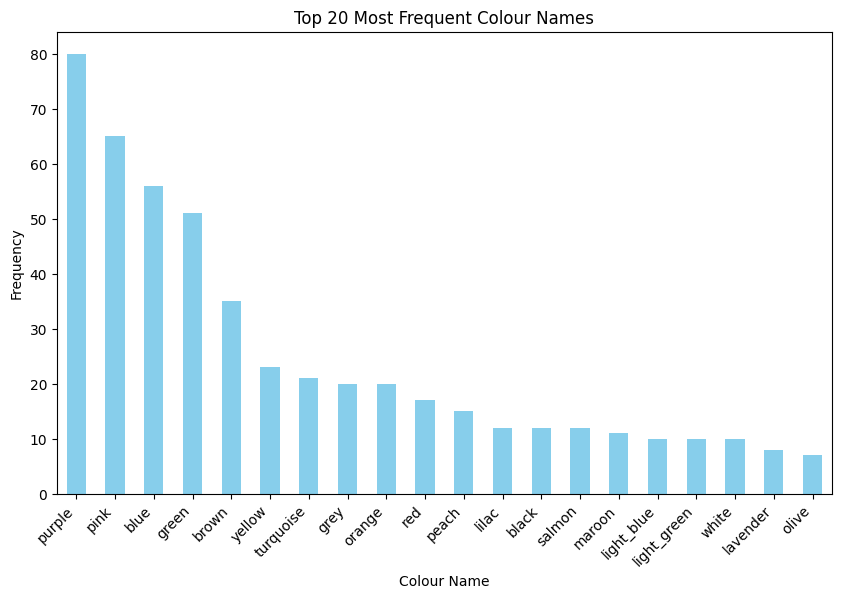

In [73]:
# Calculate the frequency of each colour name
colour_counts = modal_colour_names['colour_name'].value_counts()

# Get the most and least frequent colour names and their counts
most_frequent = colour_counts.idxmax()
least_frequent = colour_counts.idxmin()

most_frequent_count = colour_counts.max()
least_frequent_count = colour_counts.min()

print(f"The most frequent colour name is: {most_frequent} with a count of {most_frequent_count}")
print(f"The least frequent colour name is: {least_frequent} with a count of {least_frequent_count}")
# Get the top 10 most frequent colour names
top_k_colours = colour_counts.head(20)

# Plot the top 10 most frequent colour names
plt.figure(figsize=(10, 6))
top_k_colours.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Colour Names')
plt.xlabel('Colour Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [74]:
len(modal_colour_names)

600

In [75]:
print(modal_colour_names['colour_name'].value_counts())

colour_name
purple          80
pink            65
blue            56
green           51
brown           35
                ..
indigo           1
light_purple     1
hot_pink         1
light_red        1
violet           1
Name: count, Length: 62, dtype: int64


I am going to merge the minority classes into the majority classes based on euclidean distance. I could do it based on name (eg light_blue into blue), however some colours such as lime_green may be closer to light_green than it is to green, and there are colours such as yellow_green, and monolexemic terms such as gold.

In [76]:
modal_colour_names.head()


,colour_id,colour_name,r,g,b
0,533,black,0,0,0
1,534,black,28,28,28
2,535,black,49,49,49
3,536,grey,72,72,72
4,537,grey,97,97,97


In [77]:
modal_colour_names = convert_rgb_to_luv(modal_colour_names)


# Round LUV values to 4dp to reduce complexity and aid readability
modal_colour_names[['l', 'u', 'v']] = modal_colour_names[['l', 'u', 'v']].astype(float).round(4)


In [78]:
modal_colour_names.head()

,colour_id,colour_name,r,g,b,l,u,v
0,533,black,0,0,0,0.0000,-0.0000,-0.0000
1,534,black,28,28,28,10.2682,-0.0001,0.0008
2,535,black,49,49,49,20.3274,-0.0001,0.0016
3,536,grey,72,72,72,30.5933,-0.0002,0.0023
4,537,grey,97,97,97,41.1427,-0.0002,0.0032


In [79]:
# Identify minority colour names
colour_counts = modal_colour_names['colour_name'].value_counts()
threshold = 6
minority_colours = colour_counts[colour_counts <= threshold].index

print("Minority colour names:", minority_colours)

# Create a dictionary of RGB centroids by colour_name
centroids = modal_colour_names.groupby('colour_name')[['l', 'u', 'v']].mean().reset_index()

# Filter out the majority colours
majority_centroids = centroids[~centroids['colour_name'].isin(minority_colours)]
majority_luv_values = majority_centroids[['l', 'u', 'v']].values

# Get actual RGB values for minority colours
minority_luv = modal_colour_names[modal_colour_names['colour_name'].isin(minority_colours)]

# Calculate distances between actual minority RGB values and the centroids of majority colours
# (Calculating the distance between the minority RGB values and their closest neighbour yielded inaccurate results)
minority_luv_values = minority_luv[['l', 'u', 'v']].values
distances = euclidean_distances(minority_luv_values, majority_luv_values)

# Find the nearest majority colour for each minority colour
nearest_indices = np.argmin(distances, axis=1)
nearest_majority_colours = majority_centroids.iloc[nearest_indices]['colour_name'].values

# Create a mapping of minority colours to nearest majority colours
colour_merge_map = dict(zip(minority_luv['colour_name'], nearest_majority_colours))

# Create new DataFrame with the updated colour names
merged_df = modal_colour_names.copy()
merged_df['colour_name'] = merged_df['colour_name'].replace(colour_merge_map)

# Ensure the DataFrame only contains the original columns and the updated colour names
merged_df = merged_df[['colour_id', 'r', 'g', 'b', 'l', 'u', 'v', 'colour_name']]

print(merged_df.head())


Minority colour names: Index(['mauve', 'dark_purple', 'sky_blue', 'teal', 'navy_blue', 'fuchsia',
       'magenta', 'beige', 'dark_green', 'dark_teal', 'mustard', 'rose',
       'cyan', 'cream', 'tan', 'light_brown', 'burgundy', 'dark_pink',
       'mint_green', 'aqua', 'pale_yellow', 'khaki', 'plum', 'grey_green',
       'taupe', 'blue_grey', 'dark_blue', 'forest_green', 'light_pink',
       'light_grey', 'dark_yellow', 'gold', 'burnt_orange', 'chartreuse',
       'yellow_green', 'periwinkle', 'indigo', 'light_purple', 'hot_pink',
       'light_red', 'violet'],
      dtype='object', name='colour_name')
   colour_id   r   g   b        l       u       v colour_name
0        533   0   0   0   0.0000 -0.0000 -0.0000       black
1        534  28  28  28  10.2682 -0.0001  0.0008       black
2        535  49  49  49  20.3274 -0.0001  0.0016       black
3        536  72  72  72  30.5933 -0.0002  0.0023        grey
4        537  97  97  97  41.1427 -0.0002  0.0032        grey


In [80]:
print(merged_df['colour_name'].value_counts())
print(len(merged_df['colour_name'].unique()))

colour_name
purple         81
pink           72
blue           57
green          51
yellow         37
brown          35
turquoise      34
black          31
grey           27
peach          21
orange         20
red            19
white          18
maroon         18
salmon         16
lilac          15
olive          13
light_green    10
light_blue     10
lavender        8
lime_green      7
Name: count, dtype: int64
21


In [81]:
merged_df.head()

,colour_id,r,g,b,l,u,v,colour_name
0,533,0,0,0,0.0000,-0.0000,-0.0000,black
1,534,28,28,28,10.2682,-0.0001,0.0008,black
2,535,49,49,49,20.3274,-0.0001,0.0016,black
3,536,72,72,72,30.5933,-0.0002,0.0023,grey
4,537,97,97,97,41.1427,-0.0002,0.0032,grey


In [82]:
merged_centroids = merged_df.groupby('colour_name')[['l', 'u', 'v']].mean().reset_index()
#rename l u v columns to centroid_l centroid_u centroid_v
merged_centroids = merged_centroids.rename(columns={'l': 'centroid_l', 'u': 'centroid_u', 'v': 'centroid_v'})
merged_centroids.head()


,colour_name,centroid_l,centroid_u,centroid_v
0,black,14.576045,0.610284,-10.217890
1,blue,49.493049,-21.242849,-52.937681
2,brown,35.680874,29.581063,19.964646
3,green,59.589637,-30.196812,39.650022
4,grey,54.555678,4.279848,-7.010363


In [83]:
modal_colour_names_21 = merged_df.copy()

In [84]:
colour_names_21 = modal_colour_names_21['colour_name'].unique()

## Preparing the uniform data for training and testing

Calculating the probability tables for the datasets:

In [85]:
len(colour_names_62)

62

In [86]:
len(colour_names_21)

21

In [87]:
reduced_data_62 = clean_data[clean_data['colour_name'].isin(colour_names_62)]
reduced_data_21 = clean_data[clean_data['colour_name'].isin(colour_names_21)]
reduced_data_62.head()

,colour_id,colour_name,red,green,blue
0,582,grey,182,172,182
8,979,aqua,53,255,212
31,756,aqua,100,191,172
32,666,aqua,153,212,218
33,845,aqua,15,168,139


In [88]:
len(clean_data)

30600

In [89]:
print("length of reduced data for 59 colour names:", len(reduced_data_62))
print("length of reduced data for 21 colour names:", len(reduced_data_21))

length of reduced data for 59 colour names: 21250
length of reduced data for 21 colour names: 14067


In [90]:
# Use crosstab to create the frequency distribution table
freq_table_62 = pd.crosstab(reduced_data_62['colour_id'], reduced_data_62['colour_name'])
freq_table_21 = pd.crosstab(reduced_data_21['colour_id'], reduced_data_21['colour_name'])

# Preview
freq_table_21.head()

colour_name,black,blue,brown,green,grey,lavender,light_blue,light_green,lilac,lime_green,...,olive,orange,peach,pink,purple,red,salmon,turquoise,white,yellow
colour_id,,,,,,,,,,,,,,,,,,,,,
533,47,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
534,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
535,14,0,0,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536,0,0,2,0,18,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
537,0,0,0,0,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Normalize the table by dividing each row by its sum
prob_table_62 = freq_table_62.div(freq_table_62.sum(axis=1), axis=0)
prob_table_21 = freq_table_21.div(freq_table_21.sum(axis=1), axis=0)

# Reset the index to make 'colour_id' a column again
prob_table_62 = prob_table_62.reset_index()
prob_table_21 = prob_table_21.reset_index()

# Remove the name of the columns axis for a cleaner look
prob_table_62.columns.name = None
prob_table_21.columns.name = None

prob_table_62.head()

,colour_id,aqua,beige,black,blue,blue_grey,brown,burgundy,burnt_orange,chartreuse,...,salmon,sky_blue,tan,taupe,teal,turquoise,violet,white,yellow,yellow_green
0,533,0.0,0.0,0.959184,0.040816,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,534,0.0,0.0,0.977273,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,535,0.0,0.0,0.518519,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536,0.0,0.0,0.000000,0.000000,0.0,0.095238,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,537,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# Merge prob_table with modal_colour_names on 'colour_id'
cieluv_table_62 = pd.merge(prob_table_62, modal_colour_names_62, on='colour_id')
cieluv_table_21 = pd.merge(prob_table_21, modal_colour_names_21, on='colour_id')

# Rearrange columns to have RGB values in the 2nd, 3rd, and 4th columns
# Assume 'colour_id' should be the first column
columns_order_62 = ['colour_id', 'r', 'g', 'b'] + [col for col in cieluv_table_62.columns if col not in ['colour_id', 'r', 'g', 'b']]
columns_order_21 = ['colour_id', 'r', 'g', 'b'] + [col for col in cieluv_table_21.columns if col not in ['colour_id', 'r', 'g', 'b']]
cieluv_table_62 = cieluv_table_62[columns_order_62]
cieluv_table_21 = cieluv_table_21[columns_order_21]

# remove the 'colour_name' column
cieluv_table_62 = cieluv_table_62.drop(columns=['colour_name'])
cieluv_table_21 = cieluv_table_21.drop(columns=['colour_name'])

cieluv_table_21.head()


,colour_id,r,g,b,black,blue,brown,green,grey,lavender,...,pink,purple,red,salmon,turquoise,white,yellow,l,u,v
0,533,0,0,0,0.959184,0.040816,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,-0.0000,-0.0000
1,534,28,28,28,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2682,-0.0001,0.0008
2,535,49,49,49,0.560000,0.000000,0.000000,0.0,0.440000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.3274,-0.0001,0.0016
3,536,72,72,72,0.000000,0.000000,0.095238,0.0,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.5933,-0.0002,0.0023
4,537,97,97,97,0.000000,0.000000,0.000000,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.1427,-0.0002,0.0032


In [93]:
# Prepare features (LUV values) and target (probability distributions)
X_62 = cieluv_table_62[['l', 'u', 'v']].values
y_62 = cieluv_table_62[colour_names_62].values

X_21 = cieluv_table_21[['l', 'u', 'v']].values
y_21 = cieluv_table_21[colour_names_21].values

# Print the shapes to verify
print("59 Colour Names- Features shape:", X_62.shape)
print("Target shape:", y_62.shape)
print()
print("21 Colour Names- Features shape:", X_21.shape)
print("Target shape:", y_21.shape)


59 Colour Names- Features shape: (600, 3)
Target shape: (600, 62)

21 Colour Names- Features shape: (600, 3)
Target shape: (600, 21)


In [94]:
print(colour_names_21)
print()
print(colour_names_62)

['black' 'grey' 'white' 'brown' 'olive' 'green' 'blue' 'peach'
 'light_blue' 'yellow' 'light_green' 'maroon' 'purple' 'turquoise' 'pink'
 'lavender' 'lilac' 'red' 'salmon' 'orange' 'lime_green']

['black' 'grey' 'white' 'brown' 'khaki' 'grey_green' 'dark_green'
 'dark_teal' 'taupe' 'olive' 'green' 'blue' 'beige' 'light_blue' 'cream'
 'light_green' 'maroon' 'navy_blue' 'purple' 'dark_purple' 'plum'
 'burgundy' 'teal' 'turquoise' 'blue_grey' 'mauve' 'pink' 'tan' 'lavender'
 'peach' 'pale_yellow' 'aqua' 'light_grey' 'lilac' 'light_pink'
 'forest_green' 'dark_pink' 'light_brown' 'mustard' 'dark_yellow' 'yellow'
 'mint_green' 'sky_blue' 'cyan' 'red' 'dark_blue' 'rose' 'salmon'
 'burnt_orange' 'orange' 'gold' 'periwinkle' 'yellow_green' 'chartreuse'
 'indigo' 'lime_green' 'fuchsia' 'light_purple' 'hot_pink' 'magenta'
 'light_red' 'violet']


In [95]:
# Put the colour names in the same order they appear in the probability tables
colour_names_21 = prob_table_21.columns.tolist()
colour_names_21.remove('colour_id')

colour_names_62 = prob_table_62.columns.tolist()
colour_names_62.remove('colour_id')

print(colour_names_62)
print()
print(colour_names_21)
print(len(colour_names_21))


['aqua', 'beige', 'black', 'blue', 'blue_grey', 'brown', 'burgundy', 'burnt_orange', 'chartreuse', 'cream', 'cyan', 'dark_blue', 'dark_green', 'dark_pink', 'dark_purple', 'dark_teal', 'dark_yellow', 'forest_green', 'fuchsia', 'gold', 'green', 'grey', 'grey_green', 'hot_pink', 'indigo', 'khaki', 'lavender', 'light_blue', 'light_brown', 'light_green', 'light_grey', 'light_pink', 'light_purple', 'light_red', 'lilac', 'lime_green', 'magenta', 'maroon', 'mauve', 'mint_green', 'mustard', 'navy_blue', 'olive', 'orange', 'pale_yellow', 'peach', 'periwinkle', 'pink', 'plum', 'purple', 'red', 'rose', 'salmon', 'sky_blue', 'tan', 'taupe', 'teal', 'turquoise', 'violet', 'white', 'yellow', 'yellow_green']

['black', 'blue', 'brown', 'green', 'grey', 'lavender', 'light_blue', 'light_green', 'lilac', 'lime_green', 'maroon', 'olive', 'orange', 'peach', 'pink', 'purple', 'red', 'salmon', 'turquoise', 'white', 'yellow']
21


In [96]:
# Group by color_name and calculate the mean for l, u, v and drop rgb columns
centroids_62 = modal_colour_names_62.groupby('colour_name')[['l', 'u', 'v']].mean().reset_index()
centroids_21 = modal_colour_names_21.groupby('colour_name')[['l', 'u', 'v']].mean().reset_index()

# Round the LUV columns
centroids_62[['l', 'u', 'v']] = centroids_62[['l', 'u', 'v']].astype(float).round(4)
centroids_21[['l', 'u', 'v']] = centroids_21[['l', 'u', 'v']].astype(float).round(4)

# Extract centroids for unsupervised learners
initial_centroids_62 = centroids_62[['l', 'u', 'v']].values  # Transpose for skfuzzy
initial_centroids_21 = centroids_21[['l', 'u', 'v']].values  # Transpose for skfuzzy

# Initialize and fit the scaler on modal_colour_names_59
scaler_62 = StandardScaler()
scaled_data_62 = scaler_62.fit_transform(modal_colour_names_62[['l', 'u', 'v']].values)
scaled_centroids_62 = scaler_62.transform(centroids_62[['l', 'u', 'v']].values)

# Initialize and fit another scaler on modal_colour_names_23
scaler_21 = StandardScaler()
scaled_data_21 = scaler_21.fit_transform(modal_colour_names_21[['l', 'u', 'v']].values)
scaled_centroids_21 = scaler_21.transform(centroids_21[['l', 'u', 'v']].values)

## Creating the noisy data

In [97]:
# I don't want to generate too many synthetic samples and risk compromising the
# quality of the data.
def conservative_smote_oversample(data, target_ratio=0.5):
    """
    Apply SMOTE conservatively by specifying a target ratio of minority class to majority class.

    Args:
        data (DataFrame): The input DataFrame containing 'l', 'u', 'v', 'colour_name', and 'colour_id'.
        target_ratio (float): The ratio of the minority class to the majority class after SMOTE.

    Returns:
        DataFrame: The oversampled DataFrame.
    """
    # Prepare the data
    X = data[['l', 'u', 'v']]
    y = data['colour_name']

    # Calculate the desired number of samples per class
    class_counts = y.value_counts()
    max_class_count = class_counts.max()
    desired_counts = {cls: int(max_class_count * target_ratio) if count < max_class_count * target_ratio else count
                      for cls, count in class_counts.items()}

    # Apply SMOTE
    smote = SMOTE(sampling_strategy=desired_counts, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create new unique colour_id values for the synthetic samples
    max_colour_id = data['colour_id'].max()
    n_original_samples = len(data)
    new_colour_ids = range(max_colour_id + 1, max_colour_id + len(X_resampled) - n_original_samples + 1)

    # Combine original and synthetic data
    resampled_data = pd.DataFrame(X_resampled, columns=['l', 'u', 'v'])
    resampled_data['colour_name'] = y_resampled

    # Add original colour_ids back to the original samples
    resampled_data.loc[:n_original_samples-1, 'colour_id'] = data['colour_id'].values

    # Assign new colour_ids to the synthetic samples
    resampled_data.loc[n_original_samples:, 'colour_id'] = new_colour_ids

    return resampled_data

In [98]:
# Calculating the distance between the centroids
def calculate_centroid_distances(before_df, after_df):
    """
    Calculate the Euclidean distance between centroids before and after oversampling.

    Args:
        before_df (DataFrame): DataFrame containing centroids before oversampling.
        after_df (DataFrame): DataFrame containing centroids after oversampling.

    Returns:
        DataFrame: A DataFrame containing the colour_name and the calculated distance.
    """

    # Merge the before and after DataFrames on 'colour_name'
    merged_df = pd.merge(before_df, after_df, on='colour_name', suffixes=('_before', '_after'))

    # Calculate the Euclidean distance between the before and after centroids
    merged_df['distance'] = np.sqrt(
        (merged_df['centroid_l_after'] - merged_df['centroid_l_before'])**2 +
        (merged_df['centroid_u_after'] - merged_df['centroid_u_before'])**2 +
        (merged_df['centroid_v_after'] - merged_df['centroid_v_before'])**2
    )

    return merged_df[['colour_name', 'distance']]


In [99]:
def add_gaussian_noise(df, std_dev=0.1):
    """
    Add mild Gaussian noise to the 'l', 'u', and 'v' columns in the DataFrame.

    Args:
        df (DataFrame): DataFrame containing 'l', 'u', and 'v' columns.
        std_dev (float): Standard deviation of the Gaussian noise. Smaller values mean less noise.

    Returns:
        DataFrame: A DataFrame with Gaussian noise added to the LUV values.
    """

    # Apply Gaussian noise to each of the LUV columns
    df['l'] += np.random.normal(0, std_dev, df['l'].shape)
    df['u'] += np.random.normal(0, std_dev, df['u'].shape)
    df['v'] += np.random.normal(0, std_dev, df['v'].shape)

    return df

In [100]:
def add_prob_dist_to_synthetic_samples(original_data, synthetic_data, prob_table, n_neighbors=5):
    """
    Add realistic probability distributions to synthetic samples based on their nearest neighbors.

    Args:
        original_data (DataFrame): Original data containing color samples.
        synthetic_data (DataFrame): DataFrame with synthetic samples generated by SMOTE.
        prob_table (DataFrame): Probability distribution table.
        n_neighbors (int): Number of nearest neighbors to consider.

    Returns:
        DataFrame: Updated probability distribution table including synthetic samples.
    """
    # Prepare data
    X_original = original_data[['l', 'u', 'v']]
    X_synthetic = synthetic_data[['l', 'u', 'v']]
    prob_columns = prob_table.columns.difference(['colour_id', 'l', 'u', 'v'])

    # Fit Nearest Neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(X_original)
    distances, indices = nbrs.kneighbors(X_synthetic)

    # Initialize DataFrame for synthetic probabilities
    synthetic_prob_df = pd.DataFrame(index=synthetic_data.index, columns=['colour_id', 'l', 'u', 'v'] + list(prob_columns))

    for i, neighbors in enumerate(indices):
        # Extract the nearest neighbors' color ids
        neighbor_ids = original_data.iloc[neighbors]['colour_id'].values

        # Get the probability distributions for the nearest neighbors
        neighbor_probs = prob_table[prob_table['colour_id'].isin(neighbor_ids)]

        # Calculate average probabilities
        avg_prob = neighbor_probs[prob_columns].mean(axis=0)

        # Create a new row for synthetic_prob_df with l, u, v, colour_id, and average probabilities
        synthetic_sample = synthetic_data.iloc[i]
        new_row = {
            'colour_id': synthetic_sample['colour_id'],
            'l': synthetic_sample['l'],
            'u': synthetic_sample['u'],
            'v': synthetic_sample['v'],
            **avg_prob
        }

        # Append the new row to synthetic_prob_df
        synthetic_prob_df.loc[synthetic_data.index[i]] = new_row

    # Remove rows with NaN values (if any)
    synthetic_prob_df = synthetic_prob_df.dropna()

    # Concatenate the original prob_table with the synthetic_prob_df
    updated_prob_table = pd.concat([prob_table, synthetic_prob_df], ignore_index=True)

    return updated_prob_table

In [101]:
def convert_luv_to_rgb(df):
    # Extract LUV values
    luv_values = df[['l', 'u', 'v']].values

    # Convert LUV to RGB (and upscale to be 0-255)
    rgb_values = luv2rgb(luv_values) * 255

    # Store the R, G, B values back in the DataFrame
    df['r'], df['g'], df['b'] = rgb_values[:, 0], rgb_values[:, 1], rgb_values[:, 2]

    return df


In [102]:
# Define the desired column order
desired_order = ['colour_id', 'colour_name', 'r', 'g', 'b', 'l', 'u', 'v']

In [103]:
#rename red green blue to r g b
reduced_data_21 = reduced_data_21.rename(columns={'red': 'r', 'green': 'g', 'blue': 'b'})


In [104]:
# calculate l u v
reduced_data_21 = convert_rgb_to_luv(reduced_data_21)
reduced_data_21.head()

,colour_id,colour_name,r,g,b,l,u,v
0,582,grey,182,172,182,71.437906,5.116017,-6.608391
282,546,black,33,28,8,10.344887,2.828060,8.431980
283,546,black,33,28,8,10.344887,2.828060,8.431980
284,550,black,12,30,40,10.257579,-5.013619,-6.618965
285,552,black,37,23,40,10.253963,4.228714,-7.465281


In [105]:
reduced_noisy_data = add_gaussian_noise(reduced_data_21)
reduced_noisy_data.head()

,colour_id,colour_name,r,g,b,l,u,v
0,582,grey,182,172,182,71.427402,5.149835,-6.700400
282,546,black,33,28,8,10.275987,2.673326,8.323830
283,546,black,33,28,8,10.513589,2.746325,8.571176
284,550,black,12,30,40,10.416555,-5.026934,-6.637996
285,552,black,37,23,40,10.272742,4.333494,-7.481496


In [106]:
# get counts of colour names
reduced_noisy_data['colour_name'].value_counts()

,count
colour_name,
purple,2096
pink,1686
blue,1437
green,1300
brown,826
orange,621
yellow,589
grey,565
turquoise,559


In [107]:
oversampled_data = conservative_smote_oversample(reduced_noisy_data, target_ratio=0.2)
oversampled_data['colour_name'].value_counts()

,count
colour_name,
purple,2096
pink,1686
blue,1437
green,1300
brown,826
orange,621
yellow,589
grey,565
turquoise,559


In [108]:
# list unique colour ids
len(oversampled_data['colour_id'].unique())

1397

It's just over doubled the number of unique colour samples

## Preparing the Noisy Data for Training & Testing

In [109]:
# drop rgb columns, they need to be recalculated later
reduced_noisy_data = reduced_noisy_data.drop(columns=['r', 'g', 'b'])

In [110]:
# Create noisy prob table out of noisy reduced
# code not commented because it's exactly the same as what i did earlier
freq_table_noisy = pd.crosstab(reduced_noisy_data['colour_id'], reduced_noisy_data['colour_name'])
prob_table_noisy = freq_table_noisy.div(freq_table_noisy.sum(axis=1), axis=0)
prob_table_noisy = prob_table_noisy.reset_index()
prob_table_noisy.columns.name = None
cieluv_table_noisy = pd.merge(prob_table_noisy, modal_colour_names_21, on='colour_id')
columns_order_noisy = ['colour_id', 'l', 'u', 'v'] + [col for col in cieluv_table_noisy.columns if col not in ['colour_id', 'l', 'u', 'v']]
cieluv_table_noisy = cieluv_table_noisy[columns_order_noisy]
cieluv_table_noisy = cieluv_table_noisy.drop(columns=['colour_name'])
cieluv_table_noisy.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,pink,purple,red,salmon,turquoise,white,yellow,r,g,b
0,533,0.0000,-0.0000,-0.0000,0.959184,0.040816,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,534,10.2682,-0.0001,0.0008,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,28,28
2,535,20.3274,-0.0001,0.0016,0.560000,0.000000,0.000000,0.0,0.440000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,49,49
3,536,30.5933,-0.0002,0.0023,0.000000,0.000000,0.095238,0.0,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72,72,72
4,537,41.1427,-0.0002,0.0032,0.000000,0.000000,0.000000,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97,97,97


In [111]:
# drop rgb columns
cieluv_table_noisy = cieluv_table_noisy.drop(columns=['r', 'g', 'b'])

cieluv_table_noisy.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,olive,orange,peach,pink,purple,red,salmon,turquoise,white,yellow
0,533,0.0000,-0.0000,-0.0000,0.959184,0.040816,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,534,10.2682,-0.0001,0.0008,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,535,20.3274,-0.0001,0.0016,0.560000,0.000000,0.000000,0.0,0.440000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536,30.5933,-0.0002,0.0023,0.000000,0.000000,0.095238,0.0,0.857143,0.0,...,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,537,41.1427,-0.0002,0.0032,0.000000,0.000000,0.000000,0.0,1.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# get just the new synthetic colour samples
synthetic_data = oversampled_data[~oversampled_data['colour_id'].isin(reduced_data_21['colour_id'])]
synthetic_data.head()

,l,u,v,colour_name,colour_id
14067,20.378239,-0.024177,0.015978,black,1133.0
14068,10.369766,2.803950,8.377127,black,1134.0
14069,-0.084218,0.055672,-0.002164,black,1135.0
14070,0.051770,-0.114798,0.007329,black,1136.0
14071,10.130076,18.241136,-9.264525,black,1137.0


In [113]:
# create new probability distributions for synthetic samples based on the distributions of their real neighbours
noisy_prob_table = add_prob_dist_to_synthetic_samples(reduced_noisy_data, synthetic_data, cieluv_table_noisy, n_neighbors=2) # choosing 2 because I don't want to go too far away from the sample
noisy_prob_table.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,olive,orange,peach,pink,purple,red,salmon,turquoise,white,yellow
0,533,0.0,-0.0,-0.0,0.959184,0.040816,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,534,10.2682,-0.0001,0.0008,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,535,20.3274,-0.0001,0.0016,0.56,0.0,0.0,0.0,0.44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536,30.5933,-0.0002,0.0023,0.0,0.0,0.095238,0.0,0.857143,0.0,...,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,537,41.1427,-0.0002,0.0032,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
len(noisy_prob_table)

1397

In [115]:
# find just the rows of the noisy prob table whos colour id is not in reduced data 21
synthetic_probs = noisy_prob_table[~noisy_prob_table['colour_id'].isin(reduced_data_21['colour_id'])]
synthetic_probs.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,olive,orange,peach,pink,purple,red,salmon,turquoise,white,yellow
600,1133.0,20.378239,-0.024177,0.015978,0.56,0.0,0.0,0.0,0.44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,1134.0,10.369766,2.80395,8.377127,0.787879,0.0,0.151515,0.060606,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,1135.0,-0.084218,0.055672,-0.002164,0.959184,0.040816,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
603,1136.0,0.05177,-0.114798,0.007329,0.959184,0.040816,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
604,1137.0,10.130076,18.241136,-9.264525,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0


In [116]:
# data types in each column
synthetic_probs.dtypes

,0
colour_id,object
l,object
u,object
v,object
black,object
blue,object
brown,object
green,object
grey,object
lavender,object


In [117]:
# cast all numerical objects as float
noisy_prob_table = noisy_prob_table.astype(float)
noisy_prob_table.dtypes

,0
colour_id,float64
l,float64
u,float64
v,float64
black,float64
blue,float64
brown,float64
green,float64
grey,float64
lavender,float64


In [118]:
# recalculate rgb values
noisy_prob_table = convert_luv_to_rgb(noisy_prob_table)
columns_order_noisy = ['colour_id', 'r', 'g', 'b'] + [col for col in noisy_prob_table.columns if col not in ['colour_id', 'r', 'g', 'b']]
noisy_prob_table.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,pink,purple,red,salmon,turquoise,white,yellow,r,g,b
0,533.0,0.0000,-0.0000,-0.0000,0.959184,0.040816,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,534.0,10.2682,-0.0001,0.0008,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.999938,28.000061,28.000016
2,535.0,20.3274,-0.0001,0.0016,0.560000,0.000000,0.000000,0.0,0.440000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.000047,49.000029,48.999969
3,536.0,30.5933,-0.0002,0.0023,0.000000,0.000000,0.095238,0.0,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.999916,71.999970,72.000024
4,537.0,41.1427,-0.0002,0.0032,0.000000,0.000000,0.000000,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.000118,97.000076,97.000024


In [119]:
cieluv_table_noisy = noisy_prob_table.copy()
cieluv_table_noisy.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,pink,purple,red,salmon,turquoise,white,yellow,r,g,b
0,533.0,0.0000,-0.0000,-0.0000,0.959184,0.040816,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,534.0,10.2682,-0.0001,0.0008,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.999938,28.000061,28.000016
2,535.0,20.3274,-0.0001,0.0016,0.560000,0.000000,0.000000,0.0,0.440000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.000047,49.000029,48.999969
3,536.0,30.5933,-0.0002,0.0023,0.000000,0.000000,0.095238,0.0,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.999916,71.999970,72.000024
4,537.0,41.1427,-0.0002,0.0032,0.000000,0.000000,0.000000,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.000118,97.000076,97.000024


In [120]:
# Prepare features (LUV values) and target (probability distributions)
X_noisy = cieluv_table_noisy[['l', 'u', 'v']].values
y_noisy = cieluv_table_noisy[colour_names_21].values

# Print the shapes to verify
print("Noisy Data- Features shape:", X_noisy.shape)
print("Target shape:", y_noisy.shape)

Noisy Data- Features shape: (1397, 3)
Target shape: (1397, 21)


In [121]:
# find just the rows of the noisy prob table whos colour id is not in reduced data 21
synthetic_probs = noisy_prob_table[~noisy_prob_table['colour_id'].isin(reduced_data_21['colour_id'])]
synthetic_probs.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,pink,purple,red,salmon,turquoise,white,yellow,r,g,b
600,1133.0,20.378239,-0.024177,0.015978,0.560000,0.000000,0.000000,0.000000,0.44,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,49.071042,49.123625,49.093868
601,1134.0,10.369766,2.803950,8.377127,0.787879,0.000000,0.151515,0.060606,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,33.010868,28.053946,8.265546
602,1135.0,-0.084218,0.055672,-0.002164,0.959184,0.040816,0.000000,0.000000,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
603,1136.0,0.051770,-0.114798,0.007329,0.959184,0.040816,0.000000,0.000000,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.340347,0.205864
604,1137.0,10.130076,18.241136,-9.264525,0.333333,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,57.787278,4.218051,40.703863


In [122]:
# find the column with the maximum probability in the columns in colour_names_21 and add as column
synthetic_probs['colour_name'] = synthetic_probs[colour_names_21].idxmax(axis=1)
synthetic_probs.head()

,colour_id,l,u,v,black,blue,brown,green,grey,lavender,...,purple,red,salmon,turquoise,white,yellow,r,g,b,colour_name
600,1133.0,20.378239,-0.024177,0.015978,0.560000,0.000000,0.000000,0.000000,0.44,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,49.071042,49.123625,49.093868,black
601,1134.0,10.369766,2.803950,8.377127,0.787879,0.000000,0.151515,0.060606,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,33.010868,28.053946,8.265546,black
602,1135.0,-0.084218,0.055672,-0.002164,0.959184,0.040816,0.000000,0.000000,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,black
603,1136.0,0.051770,-0.114798,0.007329,0.959184,0.040816,0.000000,0.000000,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.340347,0.205864,black
604,1137.0,10.130076,18.241136,-9.264525,0.333333,0.000000,0.000000,0.000000,0.00,0.0,...,0.222222,0.0,0.0,0.0,0.0,0.0,57.787278,4.218051,40.703863,maroon


In [123]:
synthetic_probs['colour_name'].value_counts()

,count
colour_name,
white,111
green,90
maroon,76
olive,66
peach,63
salmon,53
lime_green,51
pink,43
purple,40


In [124]:
modal_colour_names_21['colour_name'].value_counts()

,count
colour_name,
purple,81
pink,72
blue,57
green,51
yellow,37
brown,35
turquoise,34
black,31
grey,27


In [125]:
modal_colour_names_ids_only = modal_colour_names_21[['colour_id', 'colour_name']]
synthetic_colour_names = synthetic_probs[['colour_id', 'colour_name']]

#concatenate
synthetic_colour_names = pd.concat([modal_colour_names_ids_only, synthetic_colour_names])

# sort by colour id
modal_colour_names_noisy = synthetic_colour_names.sort_values(by=['colour_id'])
modal_colour_names_noisy.head()

,colour_id,colour_name
0,533.0,black
1,534.0,black
2,535.0,black
3,536.0,grey
4,537.0,grey


In [126]:
synthetic_colour_names['colour_name'].value_counts()

,count
colour_name,
green,141
white,129
purple,121
pink,115
maroon,94
peach,84
olive,79
brown,75
salmon,69


In [127]:
len(modal_colour_names_noisy)

1397

In [128]:
# Perform a merge to add the l, u, v, r, g, b columns from cieluv_table_noisy to modal_colour_names_noisy
modal_colour_names_noisy = pd.merge(modal_colour_names_noisy,
                                    cieluv_table_noisy[['colour_id', 'l', 'u', 'v', 'r', 'g', 'b']],
                                    on='colour_id',
                                    how='left')

# Display the updated dataframe
modal_colour_names_noisy.head()


,colour_id,colour_name,l,u,v,r,g,b
0,533.0,black,0.0000,-0.0000,-0.0000,0.000000,0.000000,0.000000
1,534.0,black,10.2682,-0.0001,0.0008,27.999938,28.000061,28.000016
2,535.0,black,20.3274,-0.0001,0.0016,49.000047,49.000029,48.999969
3,536.0,grey,30.5933,-0.0002,0.0023,71.999916,71.999970,72.000024
4,537.0,grey,41.1427,-0.0002,0.0032,97.000118,97.000076,97.000024


In [129]:
# colour names in modal_colour_names_noisy
modal_colour_names_noisy['colour_name'].value_counts()

,count
colour_name,
green,141
white,129
purple,121
pink,115
maroon,94
peach,84
olive,79
brown,75
salmon,69


In [130]:
# Group by color_name and calculate the mean for l, u, v
centroids_noisy = modal_colour_names_noisy.groupby('colour_name')[['l', 'u', 'v']].mean().reset_index()

# Round the LUV columns
centroids_noisy[['l', 'u', 'v']] = centroids_noisy[['l', 'u', 'v']].astype(float).round(4)


# Extract centroids for unsupervised learners
initial_centroids_noisy = centroids_noisy[['l', 'u', 'v']].values  # Transpose for skfuzzy

# Initialize and fit the scaler
scaler_noisy = StandardScaler()
scaled_data_noisy = scaler_noisy.fit_transform(modal_colour_names_noisy[['l', 'u', 'v']].values)
scaled_centroids_noisy = scaler_noisy.transform(centroids_noisy[['l', 'u', 'v']].values)


# Functions for training and evaluating all models

## Custom Distance Functions



In [131]:
def hellinger_distance(p, q):
    """
    Calculate the Hellinger distance between two distributions.

    Parameters:
    p (numpy.ndarray): First probability distribution
    q (numpy.ndarray): Second probability distribution

    Returns:
    float: Hellinger distance
    """
    # Ensure both distributions are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Compute the Hellinger similarity row by row
    distance = np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2, axis=1))

    # Return the average Hellinger distance over all samples
    return np.mean(distance)

In [132]:
def hellinger_scorer(estimator, X, y):
    """
    Custom scorer function to be used with GridSearchCV.

    Parameters:
    estimator : object
        The model/estimator being evaluated.
    X : array-like
        The input samples.
    y : array-like
        The true labels/probabilities.

    Returns:
    float: Average Hellinger distance between the predicted and true probabilities.
    """
    # Get the predicted values from the estimator
    y_pred = estimator.predict(X)

    # Calculate the average Hellinger distance
    return -hellinger_distance(y_pred, y)  # Negative because GridSearchCV maximizes the scorer


## Supervised Model Functions

In [133]:
# Works with classical regression models only, to visually demonstrate the model's output for a single prediction.
def evaluate_colour_id(colour_id, cieluv_table, model):
    """ Takes the colour_id of a colour sample and a probability table containing LUV values. Predicts the probability distribution of each colour_name for
    the given colour sample, as well as the Hellinger distance between the predicted and actual probability distributions. Visualises both
    of these probability distributions as histograms.
    Args:
      colour_id (int): The colour_id of the sample.
      cieluv_table (DataFrame): A DataFrame containing the probability distribution
        of each colour_name for each colour_id.
      model (KNeighborsRegressor): A classical regression model.
    Returns:
      None
    """
    # Ensure cieluv_copy has columns 'r', 'g', and 'b'
    features = ['l', 'u', 'v']

    # Filter data for the given colour_id
    data_for_id = cieluv_table[cieluv_table['colour_id'] == colour_id]

    # Training data: Exclude the rows with the specified colour_id
    X_train = cieluv_table[cieluv_table['colour_id'] != colour_id][features].values
    y_train = cieluv_table[cieluv_table['colour_id'] != colour_id].drop(['colour_id'] + features + ['r'] + ['g'] + ['b'], axis=1).values

    # Test data: Use the filtered data for the specified colour_id
    X_test = data_for_id[features].values

    # Fit the model
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)
    y_pred = np.clip(y_pred, 0, 1)  # Ensure probabilities are in valid range

    # Create DataFrame for y_pred
    colour_names = [col for col in cieluv_table.columns if col not in ['colour_id'] + features + ['r'] + ['g'] + ['b']]
    pred_data = {
        'colour_id': [colour_id],
        **{name: [prob] for name, prob in zip(colour_names, y_pred[0])}
    }
    pred_df = pd.DataFrame(pred_data)

    actual_df = cieluv_table[cieluv_table['colour_id'] == colour_id].drop(['colour_id'] + features + ['r'] + ['g'] + ['b'], axis=1)

    # Check for consistency in column names
    actual_columns = actual_df.columns
    pred_columns = pred_df.columns[1:]  # Exclude 'colour_id'

    if set(actual_columns) != set(pred_columns):
        raise ValueError(f"Column names mismatch: Actual columns - {actual_columns}, Predicted columns - {pred_columns}")

    # Align columns
    actual_probs = actual_df[sorted(actual_columns)].values[0]
    predicted_probs = pred_df[sorted(pred_columns)].values[0]

    # Calculate Hellinger distance
    hellinger_distance = hellinger_distance(actual_probs, predicted_probs)

    # Plotting histograms side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting pred_df
    ax1.bar(pred_df.columns[1:], pred_df.iloc[0, 1:], color='skyblue')
    ax1.set_title(f'Predicted Probability Distribution (Hellinger Distance: {hellinger_distance:.2f})')
    ax1.set_xlabel('Colour Names')
    ax1.set_ylabel('Probability')
    ax1.tick_params(axis='x', rotation=90)

    # Plotting actual_df
    ax2.bar(actual_df.columns, actual_df.iloc[0], color='salmon')
    ax2.set_title('Actual Probability Distribution')
    ax2.set_xlabel('Colour Names')
    ax2.set_ylabel('Probability')
    ax2.tick_params(axis='x', rotation=90)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [134]:
# Works with classical regression models only. For neural networks, see loocv_probability_table_keras.
def loocv_probability_table(cieluv_table, colour_names, model):
  """ Carries out leave-one-out cross-validation using a given classical regression model and creates a probability table
  containing the predicted probability distribution of each colour_name for each colour_id.
  Args:
    cieluv_table (DataFrame): A DataFrame containing the probability distribution
      of each colour_name for each colour_id.
    colour_names (list): A list of colour names derived from cieluv_table.
    model (sklearn regressor): A classical regression model.
  Returns:
    predicted_probabilities (DataFrame): A DataFrame containing the predicted
      probability distribution of each colour_name for each colour_id.
  """
  colour_ids = cieluv_table['colour_id'].unique()
  features = ['l', 'u', 'v']
  # Initialize a DataFrame to store the probability distributions
  predicted_probabilities = pd.DataFrame(columns=['colour_id'] + list(colour_names))

  # Initialize a list to store Hellinger distances for each sample
  hellinger_distances = []

  for colour_id in colour_ids:
      # Filter data for the given colour_id
      data_for_id = cieluv_table[cieluv_table['colour_id'] == colour_id]

      # Training data: Exclude the rows with the specified colour_id
      X_train = cieluv_table[cieluv_table['colour_id'] != colour_id][features].values
      y_train = cieluv_table[cieluv_table['colour_id'] != colour_id].drop(['colour_id'] + features + ['r'] + ['g'] + ['b'], axis=1).values

      # Test data: Use the filtered data for the specified colour_id
      X_test = data_for_id[features].values
      y_test = data_for_id.drop(['colour_id'] + features + ['r'] + ['g'] + ['b'], axis=1).values

      # Fit the model
      model.fit(X_train, y_train)

      # Predict on the test set
      y_pred = model.predict(X_test)
      #y_pred = np.clip(y_pred, 0, 1) Ensure probabilities are in valid range

      # Calculate Hellinger distance for the current sample
      distance = hellinger_distance(y_pred, y_test)
      hellinger_distances.append(distance)

      # Prepare the results for this colour_id
      pred_data = {
          'colour_id': [colour_id],
          **{name: [prob] for name, prob in zip(colour_names, y_pred[0])}
      }
      pred_df = pd.DataFrame(pred_data)

      # Append results to the main DataFrame
      predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)

  # Calculate the average Hellinger distance
  avg_distance = np.mean(hellinger_distances)

  return predicted_probabilities, avg_distance

In [135]:
# Works with neural networks only. For classical regression models, see loocv_probability_table()
def loocv_probability_table_keras(cieluv_table, colour_names, model, epochs=100, batch_size=32):
    """
    Carries out leave-one-out cross-validation using a given Keras regression model and creates a probability table
    containing the predicted probability distribution of each colour_name for each colour_id.

    Args:
        cieluv_table (DataFrame): A DataFrame containing the probability distribution
          of each colour_name for each colour_id.
        colour_names (list): A list of colour names derived from cieluv_table.
        model (keras.Model): A compiled Keras model.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.

    Returns:
        predicted_probabilities (DataFrame): A DataFrame containing the predicted
          probability distribution of each colour_name for each colour_id.
    """
    colour_ids = cieluv_table['colour_id'].unique()
    features = ['l', 'u', 'v']

    # Initialize a DataFrame to store the probability distributions
    predicted_probabilities = pd.DataFrame(columns=['colour_id'] + list(colour_names))

    # Initialize a list to store Hellinger distances for each sample
    hellinger_distances = []

    # Reset the model weights to the initial state before fitting
    initial_weights = model.get_weights()

    for colour_id in colour_ids:
        # Filter data for the given colour_id
        data_for_id = cieluv_table[cieluv_table['colour_id'] == colour_id]

        # Training data: Exclude the rows with the specified colour_id
        X_train = cieluv_table[cieluv_table['colour_id'] != colour_id][features].values
        y_train = cieluv_table[cieluv_table['colour_id'] != colour_id].drop(['colour_id'] + features + ['r'] + ['g'] + ['b'], axis=1).values

        # Test data: Use the filtered data for the specified colour_id
        X_test = data_for_id[features].values
        y_test = data_for_id.drop(['colour_id'] + features + ['r'] + ['g'] + ['b'], axis=1).values

        # Print the shapes of the training data for debugging
        print(f"Training on colour_id {colour_id}")
        #print(f"X_train shape: {X_train.shape}")
        #print(f"y_train shape: {y_train.shape}")

        # Fit the Keras model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Reset the model weights to the initial state
        model.set_weights(initial_weights)

        # Calculate Hellinger distance for the current sample
        distance = hellinger_distance(y_pred, y_test)
        hellinger_distances.append(distance)

        # Prepare the results for this colour_id
        pred_data = {
            'colour_id': [colour_id],
            **{name: [prob] for name, prob in zip(colour_names, y_pred[0])}
        }
        pred_df = pd.DataFrame(pred_data)

        # Append results to the main DataFrame
        predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)

    # Calculate the average Hellinger distance
    avg_distance = np.mean(hellinger_distances)

    return predicted_probabilities, avg_distance

In [136]:
def predict_new_colour(r, g, b, cieluv_table, model):
    """ Predicts the name of a new colour given in RGB values.

    Args:
        r (float): Red component of the colour.
        g (float): Green component of the colour.
        b (float): Blue component of the colour.
        cieluv_table (DataFrame): The CIELUV probability table.
        model: Regressor with which to make the prediction (not neural network). Must already be
        fit to the appropriate X and y data.

    Returns:
        pred_df (Dataframe): Predicted probability distribution of colour names for the given colour.
    """
    rgb = [[r,g,b]]
    luv = rgb2luv(rgb)

    X_test = luv
    features = ['l', 'u', 'v']

    # Predict on the test set
    y_pred = knn.predict(X_test)
    y_pred = np.clip(y_pred, 0, 1)  # Ensure probabilities are in valid range

    # Create DataFrame for y_pred
    colour_names = [col for col in cieluv_table.columns if col not in ['colour_id'] + features + ['r'] + ['g'] + ['b']]
    pred_data = {
        'colour_id': [000],
        **{name: [prob] for name, prob in zip(colour_names, y_pred[0])}
    }
    pred_df = pd.DataFrame(pred_data)

    return pred_df

In [137]:
def predict_new_colour_keras(r, g, b, cieluv_table, keras_model):
    """ Predicts the name of a new colour given in RGB values.

      Args:
          r (float): Red component of the colour.
          g (float): Green component of the colour.
          b (float): Blue component of the colour.
          cieluv_table (DataFrame): The CIELUV probability table.
          model: Keras Regressor with which to make the prediction. Must already be
          fit to the appropriate X and y data.

      Returns:
          pred_df (Dataframe): Predicted probability distribution of colour names for the given colour.
      """

    rgb = [[r,g,b]]
    luv = rgb2luv(rgb)

    X_test = luv
    features = ['l', 'u', 'v']

    # Predict on the test set
    y_pred = keras_model.predict(X_test)

    # Create DataFrame for y_pred
    colour_names = [col for col in cieluv_table.columns if col not in ['colour_id'] + features + ['r'] + ['g'] + ['b']]
    pred_data = {
        'colour_id': [000],
        **{name: [prob] for name, prob in zip(colour_names, y_pred[0])}
    }
    pred_df = pd.DataFrame(pred_data)

    return pred_df

## Unsupervised Model Functions

In [138]:
def cmeans_membership_df(u, cieluv_table, colour_names):
  """ Converts a membership matrix to a DataFrame with LUV values
  and membership values for each colour_name, similar to a probability table.

  Args:
    u (numpy.ndarray): Membership matrix.
    cieluv_table (DataFrame): A DataFrame containing the probability distribution
      of each colour_name for each colour_id.
      colour_names (list): A list of colour names derived from cieluv_table.

  Returns:
    membership_df (DataFrame): A DataFrame containing the LUV values and
      membership values for each colour_name.
  """
  membership_matrix = u.T
  # Convert membership matrix to DataFrame
  membership_df = pd.DataFrame(u.T, columns=colour_names)

 # Add colour_id from the original DataFrame
  membership_df['colour_id'] = cieluv_table['colour_id'].values

  # Reorder columns to put colour_id first
  membership_df = membership_df[['colour_id'] + colour_names]

  return membership_df

In [139]:
def som_performance_report(som_model, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=False):
  """ Turns the output of a SOM model into a classification report, by measuring the distances
  between each neuron and each centroid to determine the colour name for each cluster.

  Args:
    som_model: A SOM model already trained on the scaled data, with final weights.
    scaled_data: The scaled data which the SOM has been trained on.
    centroids: The centroids of each CIELUV colour in the original data.
    scaled_centroids: The scaled centroids of each CIELUV colour in the original data, used to initialise the SOM.
    modal_colour_names: A DataFrame containing the most frequent colour_name for each colour_id.
    verbose: If True, prints the accuracy, precision, recall, and F1 score.
  Returns:
    accuracy: The accuracy score of the classification report.
  """
  # Get dimensions of the SOM
  x_dim, y_dim = som_model.get_weights().shape[:2]

  # Reshape weights to be a list of weight vectors
  som_weights = som_model.get_weights().reshape(-1, scaled_data.shape[1])

  # Compute distances from each SOM weight vector to each centroid
  distances = cdist(som_weights, scaled_centroids, metric='euclidean')

  # Get indices of the nearest centroids for each neuron
  nearest_centroid_indices = np.argmin(distances, axis=1)

  # List of cluster names corresponding to initial centroids
  cluster_names = centroids['colour_name'].values

  # Map each neuron to a cluster name
  neuron_to_cluster_name = {i: cluster_names[idx] for i, idx in enumerate(nearest_centroid_indices)}

  # Find the winning neuron for each data point
  bmu_indices = [som_model.winner(sample) for sample in scaled_data]
  bmu_indices_flat = [i * y_dim + j for i, j in bmu_indices]

  # Assign cluster names to data points
  assigned_cluster_names = [neuron_to_cluster_name[idx] for idx in bmu_indices_flat]
  # Actual cluster labels (replace `actual_labels` with your actual labels)
  actual_labels = modal_colour_names['colour_name'].values

  # Calculate metrics
  accuracy = accuracy_score(actual_labels, assigned_cluster_names)
  precision = precision_score(actual_labels, assigned_cluster_names, average='macro', zero_division=1)
  recall = recall_score(actual_labels, assigned_cluster_names, average='macro', zero_division=1)
  f1 = f1_score(actual_labels, assigned_cluster_names, average='macro', zero_division=1)

  if verbose:
    # Print the results
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

  return f1

## Classification Report & Evaluation Functions

In [140]:
def get_most_frequent_colour_name(highest_prob_colours, clean_data):
    """
    Get the most frequent colour_name from the highest_prob_colours in clean_data.

    Args:
        highest_prob_colours (list): The list of colour_names with the highest probability.
        clean_data (DataFrame): The DataFrame containing 'colour_name'.

    Returns:
        str: The most frequent colour_name from the highest_prob_colours list.
    """
    # Filter clean_data to include only the highest_prob_colours
    filtered_data = clean_data[clean_data['colour_name'].isin(highest_prob_colours)]

    # Get the most frequent colour_name from the filtered data
    if not filtered_data.empty:
        most_frequent_name = filtered_data['colour_name'].mode().iloc[0]
    else:
        most_frequent_name = highest_prob_colours[0]  # Fallback if no match found

    return most_frequent_name

def create_predicted_labels(predicted_probabilities, clean_data):
    """
    Create a DataFrame of predicted labels based on the highest predicted probabilities.

    Args:
        predicted_probabilities (DataFrame): DataFrame with colour_id and probability columns for each colour_name.
        clean_data (DataFrame): The DataFrame containing the original 'colour_name'.

    Returns:
        DataFrame: A DataFrame with colour_id and predicted_colour_name.
    """
    colour_names = predicted_probabilities.columns[1:]  # Exclude 'colour_id' column
    predicted_labels = []

    for index, row in predicted_probabilities.iterrows():
        colour_id = row['colour_id']

        # Find the colour_name(s) with the highest probability
        max_prob = row[1:].max()
        highest_prob_colours = [name for name in colour_names if row[name] == max_prob]

        if len(highest_prob_colours) > 1:
            # If there are ties, resolve by finding the most frequent colour_name in clean_data
            most_frequent_colour_name = get_most_frequent_colour_name(highest_prob_colours, clean_data)
        else:
            most_frequent_colour_name = highest_prob_colours[0]

        predicted_labels.append({
            'colour_id': colour_id,
            'predicted_colour_name': most_frequent_colour_name
        })

    return pd.DataFrame(predicted_labels)


In [141]:
def calculate_performance(predicted_labels, modal_colour_names):
  # Merge predicted_labels with modal_colour_names on 'colour_id'
  results_df = pd.merge(predicted_labels, modal_colour_names, on='colour_id')

  # Extract predictions and actual labels
  y_pred = results_df['predicted_colour_name']
  y_true = results_df['colour_name']

  # Calculate metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
  recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
  f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')


# Supervised learners

First I will use both my 62 and 21 colour name data with the K-NN models. The K-NN models are the simplest and therefore the fastest to fit and test with, so they will be good to validate my hypothesis that the rebalanced data of 21 colour names will yield better classification scores than the imbalanced data of 62 colour names.

If my hypothesis is correct, then I will fit and validate the other models using only my 23 colour name data, as it is unlikely that the imbalanced data will yield better classification scores across any of the models.

## K-NN Regressor

### Tuning and Model Selection

#### uniform data

In [ ]:
# Gridsearch on 21 colour name data
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_21, y_21)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative MSE:", grid_search.best_score_)

# Save the best model for MSE
mse_knn_21 = grid_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Best Negative MSE: -0.008466621565559362


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Gridsearch on 62 colour name data
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_62, y_62)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative MSE:", grid_search.best_score_)

# Save the best model for MSE
mse_knn_62 = grid_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Best Negative MSE: -0.002105476334298148


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# both models are the same, so I will unify them
mse_knn = mse_knn_21

negative MSE is a scikit-learn convention whereby the negative of the MSE is taken because they want the negative score to then be "higher" (closer to 0). The magnitude of the number is what matters, and in either case closer to 0 is desirable.

below is the baseline MSE for comparison.

In [ ]:
# For 23 colour names
y_mean_21 = np.mean(y_21)  # Calculate mean of target variable
y_pred_mean_21 = np.full_like(y_21, y_mean_21)  # Predict mean for all instances
mse_baseline_mean_21 = mean_squared_error(y_21, y_pred_mean_21)

# For 62 colour names
y_mean_62 = np.mean(y_62)  # Calculate mean of target variable
y_pred_mean_62 = np.full_like(y_62, y_mean_62)  # Predict mean for all instances
mse_baseline_mean_62 = mean_squared_error(y_62, y_pred_mean_62)

print(f"The baseline Mean Squared Error for the 23 colour names data is: {mse_baseline_mean_21}")
print(f"The baseline Mean Squared Error for the 62 colour names data is: {mse_baseline_mean_62}")

The baseline Mean Squared Error for the 23 colour names data is: 0.026994665948399065
The baseline Mean Squared Error for the 62 colour names data is: 0.005704427083538694


Also tuning one with Euclidean distance metric to see if the distance metric does make a significant difference:

In [ ]:
# 21 colour names
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
euclid_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
euclid_grid_search.fit(X_21, y_21)

# Print the best parameters and best score
print("Best Parameters:", euclid_grid_search.best_params_)
print("Best Negative MSE:", euclid_grid_search.best_score_)

# Save the best model for MSE
mse_euclid_knn_21 = euclid_grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
Best Negative MSE: -0.008989928484068094


In [ ]:
# 62 colour names
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
euclid_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
euclid_grid_search.fit(X_62, y_62)

# Print the best parameters and best score
print("Best Parameters:", euclid_grid_search.best_params_)
print("Best Negative MSE:", euclid_grid_search.best_score_)

# Save the best model for MSE
mse_euclid_knn_62 = euclid_grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
Best Negative MSE: -0.002194907593147798


Another GridSearchCV to tune hyperparameters, this time optimising for Hellinger distance:

In [ ]:
# 21 Colour Names
# Define the parameter grid
param_grid = {
    # try range 30 or even 50 for neighbours
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
hellinger_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring=hellinger_scorer, verbose=1)

# Fit GridSearchCV
hellinger_grid_search.fit(X_21, y_21)

# Print the best parameters and best score
print("Best Parameters:", hellinger_grid_search.best_params_)
print("Best Hellinger distance:", hellinger_grid_search.best_score_)

# Access the best model found by GridSearchCV
hellinger_knn_21 = hellinger_grid_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Hellinger distance: -0.36371929613492193


In [ ]:
# 62 Colour Names
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
hellinger_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring=hellinger_scorer, verbose=1)

# Fit GridSearchCV
hellinger_grid_search.fit(X_62, y_62)

# Print the best parameters and best score
print("Best Parameters:", hellinger_grid_search.best_params_)
print("Best Hellinger distance:", hellinger_grid_search.best_score_)

# Access the best model found by GridSearchCV
hellinger_knn_62 = hellinger_grid_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best Hellinger distance: -0.4407553527191945


Below is the baseline hellinger distance between the mean probability distribution and the actual probability distribution, for comparison

In [ ]:
baseline_hellinger_21 = hellinger_distance(y_21, y_pred_mean_21)
baseline_hellinger_62 = hellinger_distance(y_62, y_pred_mean_62)

print(f"The baseline Hellinger distance for the 21 colour names data is: {baseline_hellinger_21}")
print(f"The baseline Hellinger distance for the 62 colour names data is: {baseline_hellinger_62}")

The baseline Hellinger distance for the 21 colour names data is: 0.8177657207889453
The baseline Hellinger distance for the 62 colour names data is: 0.851248915500116


#### Noisy Data

In [ ]:
# Gridsearch on noisy data
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_noisy, y_noisy)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative MSE:", grid_search.best_score_)

# Save the best model for MSE
mse_knn_noisy = grid_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Best Negative MSE: -0.0034392078579196525


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# noisy data + euclidean distance
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
euclid_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
euclid_grid_search.fit(X_noisy, y_noisy)

# Print the best parameters and best score
print("Best Parameters:", euclid_grid_search.best_params_)
print("Best Negative MSE:", euclid_grid_search.best_score_)

# Save the best model for MSE
mse_euclid_knn_noisy = euclid_grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Best Negative MSE: -0.0034392078579196525


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# noisy data + hellinger distance scorer
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'hamming']
}

# Initialize K-NN regressor
knn = KNeighborsRegressor()

# Initialize GridSearchCV
hellinger_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring=hellinger_scorer, verbose=1)

# Fit GridSearchCV
hellinger_grid_search.fit(X_noisy, y_noisy)

# Print the best parameters and best score
print("Best Parameters:", hellinger_grid_search.best_params_)
print("Best Hellinger distance:", hellinger_grid_search.best_score_)

# Access the best model found by GridSearchCV
hellinger_knn_noisy = hellinger_grid_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best Hellinger distance: -0.11735365097555688


### Predictions and Performance Evaluation

Now to calculate the performance:

#### Uniform data

For the Hellinger model:

In [ ]:
# Call function and get predicted probability distributions
hellinger_probabilities_21, hellinger2_distance_21 = loocv_probability_table(cieluv_table_21, colour_names_21, hellinger_knn_21)
print("Average Hellinger Distance for 21 Colour Names:")
print(hellinger2_distance_21)
print()
# Call the function to turn my predicted probabilities into predicted labels.
hellinger_labels_21 = create_predicted_labels(hellinger_probabilities_21, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Hellinger distance on 23 Colour Names:')
calculate_performance(hellinger_labels_21, modal_colour_names_21)


<ipython-input-161-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for 21 Colour Names:
0.30292094527014707

Performance for K-NN optimised for Hellinger distance on 23 Colour Names:
Accuracy: 0.73
Precision: 0.69
Recall: 0.60
F1 Score: 0.61


In [ ]:
# Call function and get predicted probability distributions
hellinger_probabilities_62, hellinger2_distance_62 = loocv_probability_table(cieluv_table_62, colour_names_62, hellinger_knn_62)
print("Average Hellinger Distance for 62 Colour Names:")
print(hellinger2_distance_62)
print()
# Call the function to turn my predicted probabilities into predicted labels.
hellinger_labels_62 = create_predicted_labels(hellinger_probabilities_62, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Hellinger distance on 59 Colour Names:')
calculate_performance(hellinger_labels_62, modal_colour_names_62)


<ipython-input-161-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for 62 Colour Names:
0.383816471965829

Performance for K-NN optimised for Hellinger distance on 59 Colour Names:
Accuracy: 0.70
Precision: 0.75
Recall: 0.30
F1 Score: 0.29


For the MSE model:

In [ ]:
# Call function and get predicted probability distributions
mse_probabilities_21, mse_distance_21 = loocv_probability_table(cieluv_table_21, colour_names_21, mse_knn)
print("Average Hellinger Distance for 21 Colour Names:")
print(mse_distance_21)
print()
# Call the function to turn my predicted probabilities into predicted labels.
mse_labels_21 = create_predicted_labels(mse_probabilities_21, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Mean Squared Error on 21 Colour Names:')
calculate_performance(mse_labels_21, modal_colour_names_21)

<ipython-input-161-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for 21 Colour Names:
0.3145685504864368

Performance for K-NN optimised for Mean Squared Error on 21 Colour Names:
Accuracy: 0.72
Precision: 0.69
Recall: 0.58
F1 Score: 0.60


In [ ]:
# Call function and get predicted probability distributions
mse_probabilities_62, mse_distance_62 = loocv_probability_table(cieluv_table_62, colour_names_62, mse_knn)
print("Average Hellinger Distance for 62 Colour Names:")
print(mse_distance_62)
print()
# Call the function to turn my predicted probabilities into predicted labels.
mse_labels_62 = create_predicted_labels(mse_probabilities_62, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Mean Squared Error on 62 Colour Names:')
calculate_performance(mse_labels_62, modal_colour_names_62)

<ipython-input-161-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for 62 Colour Names:
0.38876694230208486

Performance for K-NN optimised for Mean Squared Error on 62 Colour Names:
Accuracy: 0.68
Precision: 0.76
Recall: 0.27
F1 Score: 0.25


For MSE using euclidean distance:

In [ ]:
# Call function and get predicted probability distributions
mse_euclid_probabilities_21, mse_euclid_distance_21 = loocv_probability_table(cieluv_table_21, colour_names_21, mse_euclid_knn_21)
print("Average Hellinger Distance for 21 Colour Names:")
print(mse_euclid_distance_21)
print()
# Call the function to turn my predicted probabilities into predicted labels.
mse_euclid_labels_21 = create_predicted_labels(mse_euclid_probabilities_21, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Mean Squared Error on 21 Colour Names (using Euclidean distance):')
calculate_performance(mse_euclid_labels_21, modal_colour_names_21)

<ipython-input-161-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for 21 Colour Names:
0.3055023786183061

Performance for K-NN optimised for Mean Squared Error on 21 Colour Names (using Euclidean distance):
Accuracy: 0.74
Precision: 0.75
Recall: 0.62
F1 Score: 0.64


In [ ]:
# Call function and get predicted probability distributions
mse_euclid_probabilities_62, mse_euclid_distance_62 = loocv_probability_table(cieluv_table_62, colour_names_62, mse_euclid_knn_62)
print("Average Hellinger Distance for 62 Colour Names:")
print(mse_euclid_distance_62)
print()

# Call the function to turn my predicted probabilities into predicted labels.
mse_euclid_labels_62 = create_predicted_labels(mse_euclid_probabilities_62, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Mean Squared Error on 62 Colour Names (using Euclidean distance):')
calculate_performance(mse_euclid_labels_62, modal_colour_names_62)

<ipython-input-161-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for 62 Colour Names:
0.38120628292298236

Performance for K-NN optimised for Mean Squared Error on 62 Colour Names (using Euclidean distance):
Accuracy: 0.70
Precision: 0.82
Recall: 0.30
F1 Score: 0.29


It appears that using the euclidean distance and optimising for mean squared error gives the highest f1 score as well as a statistically similar hellinger distance, when compared with optimising for hellinger distance directly.

In [ ]:
best_knn_uniform = KNeighborsRegressor(metric='euclidean', n_neighbors=8, weights='distance')

#### Noisy data

In [ ]:
# Call function and get predicted probability distributions
hellinger_probabilities_noisy, hellinger2_distance_noisy = loocv_probability_table(cieluv_table_noisy, colour_names_21, hellinger_knn_noisy)
print("Average Hellinger Distance for Noisy Data:")
print(hellinger2_distance_noisy)
print()
# Call the function to turn my predicted probabilities into predicted labels.
hellinger_labels_noisy = create_predicted_labels(hellinger_probabilities_noisy, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for Hellinger distance on Noisy Data:')
calculate_performance(hellinger_labels_noisy, modal_colour_names_noisy)


<ipython-input-122-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for Noisy Data:
0.08624155812078114

Performance for K-NN optimised for Hellinger distance on Noisy Data:
Accuracy: 0.90
Precision: 0.88
Recall: 0.87
F1 Score: 0.87


In [ ]:
# Call function and get predicted probability distributions
mse_probabilities_noisy, mse_distance_noisy = loocv_probability_table(cieluv_table_noisy, colour_names_21, mse_knn_noisy)
print("Average Hellinger Distance for Noisy Data:")
print(mse_distance_noisy)
print()
# Call the function to turn my predicted probabilities into predicted labels.
mse_labels_noisy = create_predicted_labels(mse_probabilities_noisy, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for MSE on Noisy Data:')
calculate_performance(mse_labels_noisy, modal_colour_names_noisy)


<ipython-input-122-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for Noisy Data:
0.10900036259751789

Performance for K-NN optimised for MSE on Noisy Data:
Accuracy: 0.90
Precision: 0.89
Recall: 0.88
F1 Score: 0.88


In [ ]:
# Call function and get predicted probability distributions
mse_euclid_probabilities_noisy, mse_euclid_distance_noisy = loocv_probability_table(cieluv_table_noisy, colour_names_21, mse_euclid_knn_noisy)
print("Average Hellinger Distance for Noisy Data:")
print(mse_euclid_distance_noisy)
print()
# Call the function to turn my predicted probabilities into predicted labels.
mse_euclid_labels_noisy = create_predicted_labels(mse_euclid_probabilities_noisy, clean_data)

# Calculate model's performance
print('Performance for K-NN optimised for MSE with Euclidean Distance on Noisy Data:')
calculate_performance(mse_euclid_labels_noisy, modal_colour_names_noisy)


<ipython-input-122-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance for Noisy Data:
0.10900036259751789

Performance for K-NN optimised for MSE with Euclidean Distance on Noisy Data:
Accuracy: 0.90
Precision: 0.89
Recall: 0.88
F1 Score: 0.88


They are all the same, so I'll just use the MSE euclid model as it performed the best on the uniform data.

In [ ]:
best_knn_noisy = KNeighborsRegressor(metric='euclidean', n_neighbors=4, weights='distance')

## Refining the choice of data

The rebalanced 23 colour names data yielded significantly better results across all classification metrics, therefore going forwards all the models will use it.

In [ ]:
# Remove redundant naming conventions from the variables used in training and testing models.
X = X_21
y = y_21
modal_colour_names = modal_colour_names_21
scaled_centroids = scaled_centroids_21
cieluv_table = cieluv_table_21
colour_names = colour_names_21
prob_table = prob_table_21
centroids = centroids_21
initial_centroids = initial_centroids_21
scaled_data = scaled_data_21

## Random Forest Implementation

### Tuning and Model Selection

#### Uniform data

Tuning for MSE first

In [ ]:
# Parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
}

rf_regressor = RandomForestRegressor(random_state=42)

# Use MSE scorer
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

mse_rf = grid_search.best_estimator_
y_pred = mse_rf.predict(X)

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error: 0.0005854160835951283


Best parameters: {'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Now tuning for Hellinger distance

In [ ]:
# Parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
}

rf_regressor = RandomForestRegressor(random_state=42)

# Use custom Hellinger distance scorer
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring= hellinger_scorer, verbose=2)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

hellinger_rf = grid_search.best_estimator_
y_pred = hellinger_rf.predict(X)

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error: 0.0005865463948771303


Best parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

#### Noisy data

Tuning for MSE

In [ ]:
# Parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
}

rf_regressor = RandomForestRegressor(random_state=42)

# Use MSE scorer
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X_noisy, y_noisy)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

mse_rf_noisy = grid_search.best_estimator_
y_pred = mse_rf_noisy.predict(X)

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error: 0.043401566240754655


Tuning for Hellinger Distance

In [ ]:
# Parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
}

rf_regressor = RandomForestRegressor(random_state=42)

# Use custom Hellinger distance scorer
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring= hellinger_scorer, verbose=2)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

hellinger_rf_noisy = grid_search.best_estimator_
y_pred = hellinger_rf_noisy.predict(X)

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error: 0.0005865463948771303


### Predictions and Performance Evaluation

#### Uniform Data

In [ ]:
mse_rf = RandomForestRegressor(max_depth=20, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)

In [ ]:
hellinger_rf = RandomForestRegressor(max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)


In [ ]:
# Call function and get predicted probability distributions
mse_rf_probabilities, mse_rf_distance = loocv_probability_table(cieluv_table, colour_names, mse_rf)
print("Average Hellinger Distance:")
print(mse_rf_distance)
print()
# Call the function to turn my predicted probabilities into predicted labels.
mse_rf_labels = create_predicted_labels(mse_rf_probabilities, clean_data)

# Calculate model's performance
print('Performance of Random Forest optimised for Mean Squared Error:')
calculate_performance(mse_rf_labels, modal_colour_names)

<ipython-input-123-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance:
0.30614881234135405

Performance of Random Forest optimised for Mean Squared Error:
Accuracy: 0.72
Precision: 0.70
Recall: 0.63
F1 Score: 0.64


In [ ]:
# Call function and get predicted probability distributions
hellinger_rf_probabilities, hellinger_rf_distance = loocv_probability_table(cieluv_table, colour_names, hellinger_rf)
print("Average Hellinger Distance:")
print(hellinger_rf_distance)
print()
# Call the function to turn my predicted probabilities into predicted labels.
hellinger_rf_labels = create_predicted_labels(hellinger_rf_probabilities, clean_data)

# Calculate model's performance
print('Performance of Random Forest optimised for Hellinger distance:')
calculate_performance(hellinger_rf_labels, modal_colour_names)

<ipython-input-123-51ad4a3aea08>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


Average Hellinger Distance:
0.3063564096114321

Performance of Random Forest optimised for Hellinger distance:
Accuracy: 0.73
Precision: 0.70
Recall: 0.63
F1 Score: 0.64


In [ ]:
best_rf = RandomForestRegressor(max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)

## Neural Network Implementation

I'll try shallow first and maybe go a little deeper if I can.

### Tuning and model selection

Tuning for single layered NN:

In [ ]:
# Define the function to create the Keras model
def create_model(learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y.shape[1], activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'batch_size': [8, 16, 32],
    'epochs': [50, 100, 200],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.2, 0.3, 0.4]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the GridSearchCV on the training set
grid_result = grid.fit(X, y)

# Print the best parameters and the best score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters: {'batch_size': 8, 'epochs': 200, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.001}
Best score: -0.01049328516062814


Best parameters: {'batch_size': 8, 'epochs': 200, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.001}

Now for a NN with 2 layers:

In [ ]:
# Define the function to create the Keras model
def create_model(learning_rate=0.001, dropout_rate=0.2, n_neurons=64, n_neurons_2=32):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(n_neurons_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(y.shape[1], activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'batch_size': [16, 32],
    'epochs': [50, 100, 200],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__n_neurons': [64, 96],
    'model__n_neurons_2': [32, 64]

}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the GridSearchCV on the training set
grid_result = grid.fit(X, y)

# Print the best parameters and the best score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.01, 'model__n_neurons': 96, 'model__n_neurons_2': 64}
Best score: -0.008536779336193246


{'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.01, 'model__n_neurons': 96, 'model__n_neurons_2': 64}


### Predictions and Performance Evaluation

In [ ]:
# Create single-layered model based on best parameters as chosen by gridsearch
nn_1 = Sequential()
nn_1.add(Dense(64, input_dim=3, activation='relu'))
nn_1.add(Dropout(0.2))
#nn_1.add(Dense(64, activation='relu'))
#nn_1.add(Dropout(0.2))
nn_1.add(Dense(y.shape[1], activation='softmax'))  # softmax for probability distribution

# Compile the model
nn_1.compile(optimizer=Adam(learning_rate=0.001),
            loss=CategoricalCrossentropy(),
            metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Call function to use leave-one-out regression across the whole dataset.
nn1_probabilities, nn1_distance = loocv_probability_table_keras(cieluv_table, colour_names, nn_1, epochs=200, batch_size=8)

Training on colour_id 533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Training on colour_id 534


<ipython-input-124-4d7748cd4200>:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training on colour_id 540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tr

In [ ]:
# Call the function to turn predicted probabilities into predicted labels.
nn1_labels = create_predicted_labels(nn1_probabilities, clean_data)
print("Average Hellinger Distance:")
print(nn1_distance)
print()
# Calculate model's performance
print('Performance for NN with a single layer:')
calculate_performance(nn1_labels, modal_colour_names)

Average Hellinger Distance:
0.2609965585840725

Performance for NN with a single layer:
Accuracy: 0.75
Precision: 0.70
Recall: 0.64
F1 Score: 0.65


In [ ]:
# Create 2-layered model based on best parameters as chosen by gridsearch
nn_2 = Sequential()
nn_2.add(Dense(96, input_dim=X.shape[1], activation='relu'))
nn_2.add(Dropout(0.2))
nn_2.add(BatchNormalization())
nn_2.add(Dense(64, activation='relu'))
nn_2.add(Dropout(0.2))
nn_2.add(BatchNormalization())
nn_2.add(Dense(y.shape[1], activation='softmax'))  # softmax for probability distribution

# Compile the model
nn_2.compile(optimizer=Adam(learning_rate=0.01, clipnorm=1.0),
            loss=CategoricalCrossentropy(),
            metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn2_probabilities, nn2_distance = loocv_probability_table_keras(cieluv_table, colour_names, nn_2, epochs=50, batch_size=32)

Training on colour_id 533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Training on colour_id 534


<ipython-input-124-4d7748cd4200>:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Training on colour_id 540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Training on colour_id 544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Training on colour_id 545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Tr

In [ ]:
# Call the function to turn my predicted probabilities into predicted labels.
nn2_labels = create_predicted_labels(nn2_probabilities, clean_data)
print("Average Hellinger Distance:")
print(nn2_distance)
print()
# Calculate model's performance
print('Performance for NN with two layers:')
calculate_performance(nn2_labels, modal_colour_names)

Average Hellinger Distance:
0.28514510340025767

Performance for NN with two layers:
Accuracy: 0.73
Precision: 0.68
Recall: 0.59
F1 Score: 0.61


The best performing supervised model is a single-layered neural network, so I'll now tune it on the noisy data.

### Noisy data

In [ ]:
# Define the function to create the Keras model
def create_model(learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, input_dim=X_noisy.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_noisy.shape[1], activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'batch_size': [8, 16, 32],
    'epochs': [50, 100, 200],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.2, 0.3, 0.4]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the GridSearchCV on the training set
grid_result = grid.fit(X_noisy, y_noisy)

# Print the best parameters and the best score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters: {'batch_size': 16, 'epochs': 200, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001}
Best score: -0.004240875542275538


Best parameters: {'batch_size': 16, 'epochs': 200, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001}

In [ ]:
# Create single-layered model based on best parameters as chosen by gridsearch
nn_1 = Sequential()
nn_1.add(Dense(64, input_dim=3, activation='relu'))
nn_1.add(Dropout(0.3))
#nn_1.add(Dense(64, activation='relu'))
#nn_1.add(Dropout(0.2))
nn_1.add(Dense(y.shape[1], activation='softmax'))  # softmax for probability distribution

# Compile the model
nn_1.compile(optimizer=Adam(learning_rate=0.001),
            loss=CategoricalCrossentropy(),
            metrics=['accuracy'])


In [ ]:
# Call function to use leave-one-out regression across the whole dataset.
nn1_probabilities_noisy, nn1_distance_noisy = loocv_probability_table_keras(cieluv_table_noisy, colour_names, nn_1, epochs=200, batch_size=16)

Training on colour_id 533.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 534.0


<ipython-input-124-4d7748cd4200>:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_probabilities = pd.concat([predicted_probabilities, pred_df], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 535.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 536.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 537.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 538.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 539.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 540.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 541.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training on colour_id 542.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Training on colour_id 543.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 544.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 545.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 546.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Training on colour_id 547.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training on colour_id 548.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training on colour_id 549.0
1/1 ━━━━━━

The LOOCV was disconnected at around 6 hours into execution each time by Colab's timeout feature, so LOOCV with the NN is beyond the resources of this study.

# Unsupervised learners

## Fuzzy c-means

I will try once without scaling the features, and once with. Firstly, without scaling the features, I will try initialising the clusters as 55 (number of colour names). I will compare the hellinger distance of the membership matrix and the actual probability distribution, as well as the classification ability when the membership matrix is converted to hard labels, as I did with the supervised classifiers.

In [ ]:
initial_centroids.shape

(21, 3)

### random centroids, no scaling

In [ ]:
# Prepare data
data = modal_colour_names[['l', 'u', 'v']].values.T # Transpose for skfuzzy

# Perform Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data,
    c=21,  # Number of clusters (colour names)
    m=2,           # Fuzziness parameter
    error=0.005,    # Stopping criterion
    maxiter=1000,   # Maximum number of iterations
    init=None  # Initial membership matrix
)
print(f"Fuzzy Partition Coefficient: {fpc}")
print(f"Shape of data: {data.shape}")
print(f"Shape of u: {u.shape}")

Fuzzy Partition Coefficient: 0.22837149722271846
Shape of data: (3, 600)
Shape of u: (21, 600)


In [ ]:
unscaled_random_u = u

### initialised centroids, no scaling

In [ ]:
data = cieluv_table[['l', 'u', 'v']].values  # Extract l, u, v columns from the data
centroids_values = centroids[['l', 'u', 'v']].values  # Extract l, u, v columns from centroids


# Using cdist to calculate Euclidean distance between each sample and each centroid
distances = cdist(data, centroids_values, metric='euclidean')

# Membership is inversely proportional to distance
# The closer a sample is to a centroid, the higher its membership in that cluster
epsilon = 1e-10  # A small value to prevent division by zero
distances = np.maximum(distances, epsilon)  # Replace zero distances with epsilon
initial_membership = 1 / distances

# Normalize so that the sum of memberships for each sample is 1
initial_membership = initial_membership / np.sum(initial_membership, axis=1, keepdims=True)

# Now initial_membership is a matrix of shape (number_of_samples, 21)
# which corresponds to the initial fuzzy c-partitioned matrix

# Transpose the matrix to get shape (21, number_of_samples) to match the required shape for the `init` parameter
initial_membership = initial_membership.T

initial_membership.shape

(21, 600)

In [ ]:
# Prepare data
data = modal_colour_names[['l', 'u', 'v']].values.T # Transpose for skfuzzy

# Perform Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data,
    c=21,  # Number of clusters
    m=2,           # Fuzziness parameter
    error=0.005,    # Stopping criterion
    maxiter=1000,   # Maximum number of iterations
    init=initial_membership  # Initial membership matrix
)
print(f"Fuzzy Partition Coefficient: {fpc}")
print(f"Shape of data: {data.shape}")
print(f"Shape of u: {u.shape}")

Fuzzy Partition Coefficient: 0.22580585018421084
Shape of data: (3, 600)
Shape of u: (21, 600)


In [ ]:
unscaled_initialised_u = u

### random centroids, scaled data

In [ ]:
# Prepare data
data = scaled_data.T # Transpose for skfuzzy

# Perform Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data,
    c=21,  # Number of clusters
    m=2,           # Fuzziness parameter
    error=0.005,    # Stopping criterion
    maxiter=1000,   # Maximum number of iterations
    init=None  # Initial membership matrix
)
print(f"Fuzzy Partition Coefficient: {fpc}")
print(f"Shape of data: {data.shape}")
print(f"Shape of u: {u.shape}")

Fuzzy Partition Coefficient: 0.21909665227566924
Shape of data: (3, 600)
Shape of u: (21, 600)


In [ ]:
scaled_random_u = u

### Initialised centroids, scaled data

In [ ]:
len(colour_names)

21

In [ ]:
# Prepare data
data = scaled_data.T # Transpose for skfuzzy

# Perform Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data,
    c=21,  # Number of clusters
    m=2,           # Fuzziness parameter
    error=0.005,    # Stopping criterion
    maxiter=1000,   # Maximum number of iterations
    init=initial_membership  # Initial membership matrix
)
print(f"Fuzzy Partition Coefficient: {fpc}")
print(f"Shape of data: {data.shape}")
print(f"Shape of u: {u.shape}")

Fuzzy Partition Coefficient: 0.2140002897411223
Shape of data: (3, 600)
Shape of u: (21, 600)


In [ ]:
scaled_initialised_u = u

In [ ]:
# Prepare data
data = modal_colour_names[['l', 'u', 'v']].values.T # Transpose for skfuzzy

# Fuzz params to try
fuzziness = [2, 3, 4, 5]

# Initialise best u and hellinger distance
best_u = None
best_distance = float('inf')

for i, m in enumerate(fuzziness):
  # Perform Fuzzy C-Means clustering
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
      data,
      c=21,  # Number of clusters
      m=m,           # Fuzziness parameter
      error=0.005,    # Stopping criterion
      maxiter=1000,   # Maximum number of iterations
      init=initial_membership  # Initial membership matrix
  )

  # Compute the Hellinger distance
  dist = hellinger_distance(u.T, y) # Have to transpose u to make it the same shape as y

  # Check if this is the best distance so far
  if dist < best_distance:
      best_distance = dist
      best_u = u
      best_m = m

# Turn membership matrix into a DataFrame to work with my functions
membership = cmeans_membership_df(best_u, cieluv_table, colour_names)

# Create predicted labels and performance report
print(f"Best m: {m}")
print(f"Hellinger distance for best model: {best_distance}")
print()
print("Performance of FCM Classification using tuned fuzziness parameter:")
cmeans_labels = create_predicted_labels(membership, clean_data)
calculate_performance(cmeans_labels, modal_colour_names)

Best m: 5
Hellinger distance for best model: 0.8191400416625487

Performance of FCM Classification using tuned fuzziness parameter:
Accuracy: 0.08
Precision: 0.20
Recall: 0.09
F1 Score: 0.04


Hellinger distance can be reduced slightly by tuning m to be higher, increasing the fuzziness of the clusters. This very slight decrease in distance also reduced the classification accuracy. This suggests that the slight increase in similarity is due to the membership matrix becoming more fuzzy, and not due to the membership values themselves more accurately modeling the true probabilities.

### Classification Performance & Evaluation

In [ ]:
# Compute the Hellinger distance
unscaled_random_distance = hellinger_distance(unscaled_random_u.T, y) # Have to transpose u to make it the same shape as y
print(f"Hellinger Distance: {unscaled_random_distance}")

# Turn membership matrix into a DataFrame to work with my functions
unscaled_random_membership = cmeans_membership_df(unscaled_random_u, cieluv_table, colour_names)

# Create predicted labels and performance report
print()
print("Performance of FCM Classification using unscaled data and random cluster centroids:")
ur_cmeans_labels = create_predicted_labels(unscaled_random_membership, clean_data)
calculate_performance(ur_cmeans_labels, modal_colour_names)

Hellinger Distance: 0.8443383315941301

Performance of FCM Classification using unscaled data and random cluster centroids:
Accuracy: 0.07
Precision: 0.07
Recall: 0.07
F1 Score: 0.06


The FCM with random initial centroids was completely unable to discern any underlying structure to the data. With nothing to guide it, the FCM simply clustered the data around the random initial centroids.

In [ ]:
# Compute the Hellinger distance
distance = hellinger_distance(initial_membership.T, y) # Have to transpose u to make it the same shape as y
print(f"Hellinger Distance of initial membership matrix: {distance}")

Hellinger Distance of initial membership matrix: 0.8119197142357387


In [ ]:
# Compute the Hellinger distance
unscaled_initialised_distance = hellinger_distance(unscaled_initialised_u.T, y) # Have to transpose u to make it the same shape as y
print(f"Hellinger Distance: {unscaled_initialised_distance}")

# Turn membership matrix into a DataFrame to work with my functions
unscaled_initialised_membership = cmeans_membership_df(unscaled_initialised_u, cieluv_table, colour_names)

# Create predicted labels and performance report
print()
print("Performance of FCM Classification using unscaled data and initialised membership matrix:")
ui_cmeans_labels = create_predicted_labels(unscaled_initialised_membership, clean_data)
calculate_performance(ui_cmeans_labels, modal_colour_names)

Hellinger Distance: 0.8480479342830683

Performance of FCM Classification using unscaled data and initialised membership matrix:
Accuracy: 0.15
Precision: 0.15
Recall: 0.18
F1 Score: 0.15


It is slightly better than the completely randomised FCM using the unscaled data, but still very poor.

The hellinger distance between the membership matrix and the actual probability distribution will not be good, because of the way the membership matrix is calculated using euclidean distance to centroids. Human colour categorisation rarely produces spherical clusters, but the clusters produced by euclidean distance based clustering are spherical.

The reduction in hellinger distance gained by using an initialised membership matrix is not significant.

Performing FCM on this initialised membership matrix actually increased the hellinger distance between the membership matrix and my actual probability distribution. This is likely because FCM is encouraging euclidean clusters to form in place of the meaningful structure represented by the probability distribution, which has been shaped by human perception.

Now to try with scaled data:

In [ ]:
# Compute the Hellinger distance
scaled_random_distance = hellinger_distance(scaled_random_u.T, y) # Have to transpose u to make it the same shape as y
print(f"Hellinger Distance: {scaled_random_distance}")

# Turn membership matrix into a DataFrame to work with my functions
scaled_random_membership = cmeans_membership_df(scaled_random_u, cieluv_table, colour_names)

# Create predicted labels and performance report
print()
print("Performance of FCM Classification using scaled data and random cluster centroids:")
sr_cmeans_labels = create_predicted_labels(scaled_random_membership, clean_data)
calculate_performance(sr_cmeans_labels, modal_colour_names)

Hellinger Distance: 0.8582092050017506

Performance of FCM Classification using scaled data and random cluster centroids:
Accuracy: 0.03
Precision: 0.03
Recall: 0.03
F1 Score: 0.03


There is a very minor performance increase when the data is scaled for an FCM with randomised initial cluster centroids.

In [ ]:
# Compute the Hellinger distance
scaled_initialised_distance = hellinger_distance(scaled_initialised_u.T, y) # Have to transpose u to make it the same shape as y
print(f"Hellinger Distance: {scaled_initialised_distance}")

# Turn membership matrix into a DataFrame to work with my functions
scaled_initialised_membership = cmeans_membership_df(scaled_initialised_u, cieluv_table, colour_names)

# Create predicted labels and performance report
print()
print("Performance of FCM Classification using scaled data and initialised membership matrix:")
si_cmeans_labels = create_predicted_labels(scaled_initialised_membership, clean_data)
calculate_performance(si_cmeans_labels, modal_colour_names)

Hellinger Distance: 0.8459294646623331

Performance of FCM Classification using scaled data and initialised membership matrix:
Accuracy: 0.14
Precision: 0.13
Recall: 0.14
F1 Score: 0.12


## Kohonen Network

### Model selection & tuning

In [ ]:
# Grid dimensions
x_dim, y_dim = 3, 7  # Grid size that fits 21 centroids

# Number of features
n_features = scaled_data.shape[1]  # Should match the number of features in scaled_data

#### no initialised weights, scaled

In [ ]:
# Initialize the SOM
no_centroids_som = MiniSom(x_dim, y_dim, n_features, sigma=1.0, learning_rate=0.5, random_seed=42)

# Train the SOM
num_iterations = 10000
no_centroids_som.train(scaled_data, num_iterations)

In [ ]:
# Define the parameter grid
sigma_values = [0.5, 1.0]
learning_rate_values = [0.1, 0.3]
neighborhood_functions = ['gaussian', 'mexican_hat']
topologies = ['rectangular', 'hexagonal']
activation_distances = ['euclidean', 'cosine', 'manhattan', 'chebyshev']

# Calculate the total number of combinations
total_combinations = len(sigma_values) * len(learning_rate_values) * len(neighborhood_functions) * len(topologies) * len(activation_distances)
print(f"Starting grid search over {total_combinations} combinations.")

# Track the best SOM and accuracy
best_f1 = 0
best_params = None
best_som = None

# Start time
start_time = time.time()

# Grid search loop
for i, (sigma, learning_rate, neighborhood_function, topology, activation_distance) in enumerate(product(
        sigma_values, learning_rate_values, neighborhood_functions, topologies, activation_distances), start=1):

    # Initialize the SOM with the current parameters
    som = MiniSom(x=x_dim, y=y_dim, input_len=n_features, sigma=sigma, learning_rate=learning_rate,
                  neighborhood_function=neighborhood_function, topology=topology,
                  activation_distance=activation_distance, random_seed=42)

    # Train the SOM
    num_iterations = 10000
    som.train(scaled_data, num_iterations)

    # Evaluate the performance
    f1 = som_performance_report(som, scaled_data, centroids, scaled_centroids, modal_colour_names)

    # Check if this is the best f1 so far
    if f1 > best_f1:
        best_f1 = f1
        best_params = (sigma, learning_rate, neighborhood_function, topology, activation_distance)
        best_no_centroids_som = som

    # Print progress every 50 iterations
    if i % 20 == 0 or i == total_combinations:
        elapsed_time = time.time() - start_time
        elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print(f"{i}/{total_combinations}. Time elapsed: {elapsed_str}")

# Output the best parameters and corresponding f1
print(f"Best Parameters: sigma={best_params[0]}, learning_rate={best_params[1]}, "
      f"neighborhood_function={best_params[2]}, topology={best_params[3]}, activation_distance={best_params[4]}")
print(f"Best F1 Score: {best_f1}")


Starting grid search over 64 combinations.
20/64. Time elapsed: 00:00:09
40/64. Time elapsed: 00:00:19
60/64. Time elapsed: 00:00:28
64/64. Time elapsed: 00:00:30
Best Parameters: sigma=0.5, learning_rate=0.1, neighborhood_function=gaussian, topology=hexagonal, activation_distance=manhattan
Best F1 Score: 0.4124469867494182



Best Parameters: sigma=0.5, learning_rate=0.1, neighborhood_function=gaussian, topology=hexagonal, activation_distance=manhattan

#### weights initialised with centroids, scaled

In [ ]:
# Initialize the SOM
som = MiniSom(x_dim, y_dim, n_features, sigma=1.0, learning_rate=0.5, random_seed=42)

# Initialize the weights
# Centroids should have shape (21, 3), where 21 is the number of centroids and 3 is the number of features

# use if number of classes is a prime number
# padded_centroids = np.vstack([scaled_centroids, np.zeros((x_dim * y_dim - len(scaled_centroids), n_features))])

# Reshape centroids to fit SOM grid shape
initial_weights = scaled_centroids.reshape(x_dim, y_dim, n_features)

# Assign the weights to the SOM
som.weights = initial_weights

In [ ]:
# Train the SOM
num_iterations = 10000
som.train(scaled_data, num_iterations)

trying a gridsearch approach

In [ ]:
# Define the parameter grid
sigma_values = [0.5, 1.0]
learning_rate_values = [0.1, 0.3]
neighborhood_functions = ['gaussian', 'mexican_hat']
topologies = ['rectangular', 'hexagonal']
activation_distances = ['euclidean', 'cosine', 'manhattan', 'chebyshev']

# Calculate the total number of combinations
total_combinations = len(sigma_values) * len(learning_rate_values) * len(neighborhood_functions) * len(topologies) * len(activation_distances)
print(f"Starting grid search over {total_combinations} combinations.")

# Track the best SOM and f1
best_f1 = 0
best_params = None
best_som = None

# Start time
start_time = time.time()

# Grid search loop
for i, (sigma, learning_rate, neighborhood_function, topology, activation_distance) in enumerate(product(
        sigma_values, learning_rate_values, neighborhood_functions, topologies, activation_distances), start=1):

    # Initialize the SOM with the current parameters
    som = MiniSom(x=x_dim, y=y_dim, input_len=n_features, sigma=sigma, learning_rate=learning_rate,
                  neighborhood_function=neighborhood_function, topology=topology,
                  activation_distance=activation_distance, random_seed=42)

    # Initialize the weights with the centroids
    som.weights = initial_weights

    # Train the SOM
    num_iterations = 10000
    som.train(scaled_data, num_iterations)

    # Evaluate the performance
    f1 = som_performance_report(som, scaled_data, centroids, scaled_centroids, modal_colour_names)

    # Check if this is the best f1 so far
    if f1 > best_f1:
        best_f1 = f1
        best_params = (sigma, learning_rate, neighborhood_function, topology, activation_distance)
        best_som = som

    # Print progress every 50 iterations
    if i % 20 == 0 or i == total_combinations:
        elapsed_time = time.time() - start_time
        elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print(f"{i}/{total_combinations}. Time elapsed: {elapsed_str}")

# Output the best parameters and corresponding f1
print(f"Best Parameters: sigma={best_params[0]}, learning_rate={best_params[1]}, "
      f"neighborhood_function={best_params[2]}, topology={best_params[3]}, activation_distance={best_params[4]}")
print(f"Best F1 Score: {best_f1}")


Starting grid search over 64 combinations.
20/64. Time elapsed: 00:00:10
40/64. Time elapsed: 00:00:20
60/64. Time elapsed: 00:00:30
64/64. Time elapsed: 00:00:32
Best Parameters: sigma=0.5, learning_rate=0.1, neighborhood_function=gaussian, topology=hexagonal, activation_distance=manhattan
Best F1 Score: 0.4124469867494182


#### unscaled

In [ ]:
# Initialize the SOM
unscaled_som = MiniSom(x_dim, y_dim, n_features, sigma=1.0, learning_rate=0.5, random_seed=42)

# Initialize the weights
# Centroids should have shape (21, 3), where 21 is the number of centroids and 3 is the number of features

# use if number of classes is a prime number
# padded_centroids = np.vstack([scaled_centroids, np.zeros((x_dim * y_dim - len(scaled_centroids), n_features))])

# Reshape centroids to fit SOM grid shape
initial_weights = scaled_centroids.reshape(x_dim, y_dim, n_features)

# Assign the weights to the SOM
unscaled_som.weights = initial_weights
# Train the SOM
num_iterations = 10000
unscaled_som.train(data.T, num_iterations)

In [ ]:
# Initialize the SOM
unscaled_no_centroids_som = MiniSom(x_dim, y_dim, n_features, sigma=1.0, learning_rate=0.5, random_seed=42)

# Train the SOM
num_iterations = 10000
unscaled_no_centroids_som.train(data.T, num_iterations)

#### Noisy data

In [ ]:
len(centroids_noisy)

21

In [ ]:
initial_weights_noisy = scaled_centroids_noisy.reshape(x_dim, y_dim, n_features)

In [ ]:
# Define the parameter grid
sigma_values = [0.5, 1.0]
learning_rate_values = [0.1, 0.3]
neighborhood_functions = ['gaussian', 'mexican_hat']
topologies = ['rectangular', 'hexagonal']
activation_distances = ['euclidean', 'cosine', 'manhattan', 'chebyshev']

# Calculate the total number of combinations
total_combinations = len(sigma_values) * len(learning_rate_values) * len(neighborhood_functions) * len(topologies) * len(activation_distances)
print(f"Starting grid search over {total_combinations} combinations.")

# Track the best SOM and f1
best_f1 = 0
best_params = None
best_som = None

# Start time
start_time = time.time()

# Grid search loop
for i, (sigma, learning_rate, neighborhood_function, topology, activation_distance) in enumerate(product(
        sigma_values, learning_rate_values, neighborhood_functions, topologies, activation_distances), start=1):

    # Initialize the SOM with the current parameters
    som = MiniSom(x=x_dim, y=y_dim, input_len=n_features, sigma=sigma, learning_rate=learning_rate,
                  neighborhood_function=neighborhood_function, topology=topology,
                  activation_distance=activation_distance, random_seed=42)

    # Initialize the weights with the centroids
    som.weights = initial_weights_noisy

    # Train the SOM
    num_iterations = 10000
    som.train(scaled_data_noisy, num_iterations)

    # Evaluate the performance
    f1 = som_performance_report(som, scaled_data_noisy, centroids_noisy, scaled_centroids_noisy, modal_colour_names_noisy)

    # Check if this is the best f1 so far
    if f1 > best_f1:
        best_f1 = f1
        best_params = (sigma, learning_rate, neighborhood_function, topology, activation_distance)
        best_som_noisy = som

    # Print progress every 50 iterations
    if i % 20 == 0 or i == total_combinations:
        elapsed_time = time.time() - start_time
        elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print(f"{i}/{total_combinations}. Time elapsed: {elapsed_str}")

# Output the best parameters and corresponding f1
print(f"Best Parameters: sigma={best_params[0]}, learning_rate={best_params[1]}, "
      f"neighborhood_function={best_params[2]}, topology={best_params[3]}, activation_distance={best_params[4]}")
print(f"Best F1 Score: {best_f1}")


Starting grid search over 64 combinations.
20/64. Time elapsed: 00:00:10
40/64. Time elapsed: 00:00:20
60/64. Time elapsed: 00:00:30
64/64. Time elapsed: 00:00:32
Best Parameters: sigma=1.0, learning_rate=0.1, neighborhood_function=gaussian, topology=rectangular, activation_distance=euclidean
Best F1 Score: 0.42875192545716745


### Classification performance & evaluation

After training the SOM, compare each neuron’s weight vector with the initial centroids to determine the closest match. For each data point, determine the closest neuron and assign the corresponding cluster name. Then, use the actual cluster labels and the cluster names assigned by the SOM to create the contingency matrix.

In [ ]:
print("Classification report for SOM using scaled data and weights initialised by centroids:")
print()
scaled_initialised_f1 = som_performance_report(som, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=True)

Classification report for SOM using scaled data and weights initialised by centroids:

Accuracy: 0.09
Precision: 0.96
Recall: 0.05
F1 Score: 0.01


In [ ]:
print("Classification report for SOM using scaled data and default weights:")
print()
scaled_default_f1 = som_performance_report(no_centroids_som, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=True)

Classification report for SOM using scaled data and default weights:

Accuracy: 0.46
Precision: 0.59
Recall: 0.43
F1 Score: 0.35


In [ ]:
print("Classification report for SOM using unscaled data and weights initialised by centroids:")
print()
unscaled_initialised_f1 = som_performance_report(unscaled_som, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=True)

Classification report for SOM using unscaled data and weights initialised by centroids:

Accuracy: 0.12
Precision: 0.91
Recall: 0.05
F1 Score: 0.01


In [ ]:
print("Classification report for SOM using unscaled data and default weights:")
print()
unscaled_default_f1 = som_performance_report(unscaled_no_centroids_som, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=True)

Classification report for SOM using unscaled data and default weights:

Accuracy: 0.12
Precision: 0.91
Recall: 0.05
F1 Score: 0.01


In [ ]:
print("Classification report for SOM using scaled data and initialised weights, tuned with a grid search:")
print()
tuned_f1 = som_performance_report(best_som, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=True)

Classification report for SOM using scaled data and initialised weights, tuned with a grid search:

Accuracy: 0.53
Precision: 0.60
Recall: 0.48
F1 Score: 0.41


In [ ]:
print("Classification report for SOM using scaled data and default weights, tuned with a grid search:")
print()
tuned_default_f1 = som_performance_report(best_no_centroids_som, scaled_data, centroids, scaled_centroids, modal_colour_names, verbose=True)

Classification report for SOM using scaled data and default weights, tuned with a grid search:

Accuracy: 0.53
Precision: 0.60
Recall: 0.48
F1 Score: 0.41


The classification accuracy is better than the FCM, though initialising the weights using centroids has no significant impact on performance.

#### Noisy Data

In [ ]:
best_som_noisy = MiniSom(x=x_dim, y=y_dim, input_len=n_features, sigma=1.0, learning_rate=0.1, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=42)

In [ ]:
print("Classification report for SOM using scaled data and initialised weights, tuned with a grid search on noisy data:")
print()
tuned_f1 = som_performance_report(best_som_noisy, scaled_data_noisy, centroids_noisy, scaled_centroids_noisy, modal_colour_names_noisy, verbose=True)

Classification report for SOM using scaled data and initialised weights, tuned with a grid search on noisy data:

Accuracy: 0.31
Precision: 0.68
Recall: 0.29
F1 Score: 0.18


# Load and Save Models

## Best Supervised Models

### Uniform data

In [ ]:
best_knn = KNeighborsRegressor(metric='euclidean', n_neighbors=8, weights='distance')
best_knn.fit(X, y)

In [ ]:
# Create single-layered model based on best parameters as chosen by gridsearch
nn_1 = Sequential()
nn_1.add(Dense(64, input_dim=3, activation='relu'))
nn_1.add(Dropout(0.2))
#nn_1.add(Dense(64, activation='relu'))
#nn_1.add(Dropout(0.2))
nn_1.add(Dense(y.shape[1], activation='softmax'))  # softmax for probability distribution

# Compile the model
nn_1.compile(optimizer=Adam(learning_rate=0.001),
            loss=CategoricalCrossentropy(),
            metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn_1.fit(X, y, epochs=200, batch_size=8)
nn_1.save('/content/drive/MyDrive/dissertation/nn_1.keras')

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0546 - loss: 17.7913
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2173 - loss: 7.7817
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3245 - loss: 4.9462
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3397 - loss: 3.9845
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3477 - loss: 3.4610
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3960 - loss: 3.0004
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4437 - loss: 2.6647
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4426 - loss: 2.4475
Epoch 9/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4485 - loss: 2.1424
Epoch 10/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4069 - loss: 2.2622
Epoch 11/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4779 - loss: 1.8758
Epoch 12/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

### Noisy Data

In [ ]:
noisy_knn = KNeighborsRegressor(metric='euclidean', n_neighbors=8, weights='distance')
noisy_knn.fit(X_noisy, y_noisy)

In [ ]:
# Create single-layered model based on best parameters as chosen by gridsearch
nn_1_noisy = Sequential()
nn_1_noisy.add(Dense(64, input_dim=3, activation='relu'))
nn_1_noisy.add(Dropout(0.3))
#nn_1.add(Dense(64, activation='relu'))
#nn_1.add(Dropout(0.2))
nn_1_noisy.add(Dense(y.shape[1], activation='softmax'))  # softmax for probability distribution

# Compile the model
nn_1_noisy.compile(optimizer=Adam(learning_rate=0.001),
            loss=CategoricalCrossentropy(),
            metrics=['accuracy'])

nn_1_noisy.fit(X_noisy, y_noisy, epochs=100, batch_size=16)
nn_1_noisy.save('/content/drive/MyDrive/dissertation/nn_1_noisy.keras')

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1006 - loss: 15.5456
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2151 - loss: 6.2796
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2817 - loss: 4.2880
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3488 - loss: 3.1979
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3658 - loss: 2.6430
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4165 - loss: 2.2853
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4004 - loss: 2.1083
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3741 - loss: 2.0127
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4589 - loss: 1.8006
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4993 - loss: 1.6828
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4774 - loss: 1.7374
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

## Best Unsupervised Model

In [ ]:
# Best SOM:
num_iterations = 10000

# Grid dimensions
x_dim, y_dim = 3, 7  # Grid size that fits 21 centroids

# Reshape centroids to fit SOM grid shape
initial_weights = scaled_centroids.reshape(x_dim, y_dim, n_features)

# Number of features
n_features = scaled_data.shape[1]  # Should match the number of features in scaled_data

overall_best_som = MiniSom(x=x_dim, y=y_dim, input_len=n_features, sigma=0.5, learning_rate=0.1, neighborhood_function='gaussian', topology='hexagonal', activation_distance='manhattan', random_seed=42)

# Initialize the weights with the provided centroids
overall_best_som.weights = scaled_centroids.reshape(x_dim, y_dim, n_features)

# Train the SOM
num_iterations = 10000
overall_best_som.train(scaled_data, num_iterations)

### Noisy

In [ ]:
initial_weights_noisy = scaled_centroids_noisy.reshape(x_dim, y_dim, n_features)
best_som_noisy = MiniSom(x=x_dim, y=y_dim, input_len=n_features, sigma=1.0, learning_rate=0.1, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=42)
best_som_noisy.weights = initial_weights_noisy
best_som_noisy.train(scaled_data_noisy, num_iterations)

# Generalisation tests

## Functions for Generalising and Visualising Data

In [ ]:
def convert_image_to_luv(image_array):
    luv_img = rgb2luv((image_array/255))

    rounded_array = np.round(luv_img.astype(float), 4)

    reshaped_array = rounded_array.reshape(-1, 3)
    # Convert to DataFrame
    #luv_df = pd.DataFrame(luv_img[2], columns=['l', 'u', 'v']).astype(float)

    luv_df = pd.DataFrame(reshaped_array, columns=['l', 'u', 'v']).astype(float)

    return luv_df, luv_img

In [ ]:
def predict_new_colours(luv_df, model, colour_names):
    """
    Predicts the name of a new colour given in LUV values.

    Args:
        luv_df (DataFrame): DataFrame containing 'l', 'u', and 'v' columns.
        model: Trained regression model to make the prediction.
        colour)_names (list): List of colour names.

    Returns:
        DataFrame: DataFrame with an additional column 'predicted_name' containing the predicted colour names.
    """

    # Predict on the LUV values in the DataFrame
    X_test = luv_df[['l', 'u', 'v']].values
    y_pred = model.predict(X_test)

    # Find the index of the maximum probability for each prediction
    pred_indices = np.argmax(y_pred, axis=1)

    # Map the indices to color names
    pred_names = [colour_names[idx] for idx in pred_indices]

    # Add the predictions to the DataFrame
    luv_df['colour_name'] = pred_names

    # round l u v columns in luv_df
    luv_df[['l', 'u', 'v']] = luv_df[['l', 'u', 'v']].astype(float).round(4)

    return luv_df


In [ ]:
def predict_new_colours_som(luv_df, som_model, centroids, scaled_centroids, colour_names):
    """
    Predicts the color name for each pixel in an image using a trained SOM model.

    Args:
        image_luv_df (DataFrame): DataFrame containing 'l', 'u', 'v' columns for each pixel.
        som_model: Trained SOM model.
        centroids (DataFrame): DataFrame of original centroids with 'colour_name' column.
        scaled_centroids (array): Scaled centroid values used for SOM training.
        colour_names (list): List of color names corresponding to centroids.

    Returns:
        DataFrame: DataFrame with an additional column 'predicted_colour_name' containing the predicted color names.
    """

    # Get the SOM dimensions
    x_dim, y_dim = som_model.get_weights().shape[:2]

    # Reshape the SOM weights to get a list of weight vectors
    som_weights = som_model.get_weights().reshape(-1, luv_df.shape[1])

    # Compute the distances from each SOM weight vector to each centroid
    distances = cdist(som_weights, scaled_centroids, metric='euclidean')

    # Get the indices of the nearest centroids for each neuron
    nearest_centroid_indices = np.argmin(distances, axis=1)

    # Map each SOM neuron to a cluster (color name)
    neuron_to_cluster_name = {i: colour_names[idx] for i, idx in enumerate(nearest_centroid_indices)}

    # Find the BMU for each pixel in the image
    bmu_indices = [som_model.winner(sample) for sample in luv_df[['l', 'u', 'v']].values]
    bmu_indices_flat = [i * y_dim + j for i, j in bmu_indices]

    # Assign the predicted color name to each pixel based on its BMU
    predicted_colour_names = [neuron_to_cluster_name[idx] for idx in bmu_indices_flat]

    # Add the predicted colour names to the DataFrame
    luv_df['colour_name'] = predicted_colour_names

    # round l u v columns in luv_df
    luv_df[['l', 'u', 'v']] = luv_df[['l', 'u', 'v']].astype(float).round(4)

    return luv_df



In [ ]:
# Function to check if a pixel is in lookup_dict
def is_in_lookup_dict(pixel, lookup_dict):
    l, u, v = np.round(float(pixel[0]), 4), np.round(float(pixel[1]), 4), np.round(float(pixel[2]), 4)
    return (l, u, v) in lookup_dict

# Apply the function to check for all pixels
def replace_pixels_with_centroids(luv_array, lookup_dict):
    flat_array = luv_array.reshape(-1, 3)
    output_array = np.zeros_like(flat_array)

    for i, pixel in enumerate(flat_array):
        if not is_in_lookup_dict(pixel, lookup_dict):
            raise ValueError(f"Pixel not found: {pixel}")
        else:
            l, u, v = round(float(pixel[0]), 4), round(float(pixel[1]), 4), round(float(pixel[2]), 4)
            output_array[i] = lookup_dict[(l, u, v)]

    return output_array.reshape(luv_array.shape)

In [ ]:
#rename l u v columns to centroid_l centroid_u centroid_v
centroids2 = centroids.rename(columns={'l': 'centroid_l', 'u': 'centroid_u', 'v': 'centroid_v'})
centroids2.head()

,colour_name,centroid_l,centroid_u,centroid_v
0,black,14.5760,0.6103,-10.2179
1,blue,49.4930,-21.2428,-52.9377
2,brown,35.6809,29.5811,19.9646
3,green,59.5896,-30.1968,39.6500
4,grey,54.5557,4.2798,-7.0104


In [ ]:
#rename l u v columns to centroid_l centroid_u centroid_v
centroids2_noisy = centroids_noisy.rename(columns={'l': 'centroid_l', 'u': 'centroid_u', 'v': 'centroid_v'})
centroids2_noisy.head()

,colour_name,centroid_l,centroid_u,centroid_v
0,black,12.0276,0.3007,-4.5570
1,blue,51.2345,-21.9489,-51.0693
2,brown,33.2421,27.8588,16.3209
3,green,61.6005,-24.5057,49.5317
4,grey,58.3979,4.1381,-8.5951


In [ ]:
centroids.head()

,colour_name,l,u,v
0,black,14.5760,0.6103,-10.2179
1,blue,49.4930,-21.2428,-52.9377
2,brown,35.6809,29.5811,19.9646
3,green,59.5896,-30.1968,39.6500
4,grey,54.5557,4.2798,-7.0104


In [ ]:
def predict_image(original_image_path, new_image_path, model):
  # First: Load in the image as an array and convert to LUV

  # load the image
  print("Loading image...")
  img = load_img(original_image_path)

  # convert to numpy array
  img_array = img_to_array(img)

  # Create DataFrame
  luv_df, luv_array = convert_image_to_luv(img_array)

  # Next: make colour name predictions and calculate new centroids.

  # Make predictions on image data
  print("Predicting colours..")
  model_pred_df = predict_new_colours(luv_df, model, colour_names)

  # Merge the centroid values into the combined_df
  model_centroids_df = pd.merge(model_pred_df, centroids2, on='colour_name', how='left')

  # Finally: For each pixel in the image array, replace its LUV values with the centroid of the colour it has been classified as.

  # Create the lookup dictionary
  # The key will be a tuple of (l, u, v) and the value will be the corresponding centroids
  lookup_dict = {(row['l'], row['u'], row['v']):
                (row['centroid_l'], row['centroid_u'], row['centroid_v'])
                for _, row in model_centroids_df.iterrows()}

  # Use the lookup dictionary to create a new image array out of the predicted colours and corresponding centroids
  print("Replacing pixels with centroids..")
  model_img_array = replace_pixels_with_centroids(luv_array, lookup_dict)

  # Convert back to rgb image and save as png.
  print("Converting the array back to an RGB image and saving...")
  model_img_rgb = luv2rgb(model_img_array)
  model_img = array_to_img(model_img_rgb)
  model_img.save(new_image_path)
  print(f"Image saved as {new_image_path}")

  # Absolute nightmare


In [ ]:
def predict_image_som(original_image_path, new_image_path, som_model, centroids, scaled_centroids, colour_names):
  # First: Load in the image as an array and convert to LUV

  # load the image
  print("Loading image...")
  img = load_img(original_image_path)

  # convert to numpy array
  img_array = img_to_array(img)

  # Create DataFrame
  luv_df, luv_array = convert_image_to_luv(img_array)

  # Next: make colour name predictions and calculate new centroids.

  # Make predictions on image data
  print("Predicting colours..")
  model_pred_df = predict_new_colours_som(luv_df, som_model, centroids, scaled_centroids, colour_names)

  # Merge the centroid values into the combined_df
  model_centroids_df = pd.merge(model_pred_df, centroids2, on='colour_name', how='left')

  # Finally: For each pixel in the image array, replace its LUV values with the centroid of the colour it has been classified as.

  # Create the lookup dictionary
  # The key will be a tuple of (l, u, v) and the value will be the corresponding centroids
  lookup_dict = {(row['l'], row['u'], row['v']):
                (row['centroid_l'], row['centroid_u'], row['centroid_v'])
                for _, row in model_centroids_df.iterrows()}

  # Use the lookup dictionary to create a new image array out of the predicted colours and corresponding centroids
  print("Replacing pixels with centroids..")
  model_img_array = replace_pixels_with_centroids(luv_array, lookup_dict)

  # Convert back to rgb image and save as png.
  print("Converting the array back to an RGB image and saving...")
  model_img_rgb = luv2rgb(model_img_array)
  model_img = array_to_img(model_img_rgb)
  model_img.save(new_image_path)
  print(f"Image saved as {new_image_path}")


In [ ]:
def predict_image_som_noisy(original_image_path, new_image_path, som_model, centroids, scaled_centroids, colour_names):
  # First: Load in the image as an array and convert to LUV

  # load the image
  print("Loading image...")
  img = load_img(original_image_path)

  # convert to numpy array
  img_array = img_to_array(img)

  # Create DataFrame
  luv_df, luv_array = convert_image_to_luv(img_array)

  # Next: make colour name predictions and calculate new centroids.

  # Make predictions on image data
  print("Predicting colours..")
  model_pred_df = predict_new_colours_som(luv_df, som_model, centroids, scaled_centroids, colour_names)

  # Merge the centroid values into the combined_df
  model_centroids_df = pd.merge(model_pred_df, centroids2_noisy, on='colour_name', how='left')

  # Finally: For each pixel in the image array, replace its LUV values with the centroid of the colour it has been classified as.

  # Create the lookup dictionary
  # The key will be a tuple of (l, u, v) and the value will be the corresponding centroids
  lookup_dict = {(row['l'], row['u'], row['v']):
                (row['centroid_l'], row['centroid_u'], row['centroid_v'])
                for _, row in model_centroids_df.iterrows()}

  # Use the lookup dictionary to create a new image array out of the predicted colours and corresponding centroids
  print("Replacing pixels with centroids..")
  model_img_array = replace_pixels_with_centroids(luv_array, lookup_dict)

  # Convert back to rgb image and save as png.
  print("Converting the array back to an RGB image and saving...")
  model_img_rgb = luv2rgb(model_img_array)
  model_img = array_to_img(model_img_rgb)
  model_img.save(new_image_path)
  print(f"Image saved as {new_image_path}")


In [ ]:
def predict_image_noisy(original_image_path, new_image_path, model):
  # First: Load in the image as an array and convert to LUV

  # load the image
  print("Loading image...")
  img = load_img(original_image_path)

  # convert to numpy array
  img_array = img_to_array(img)

  # Create DataFrame
  luv_df, luv_array = convert_image_to_luv(img_array)

  # Next: make colour name predictions and calculate new centroids.

  # Make predictions on image data
  print("Predicting colours..")
  model_pred_df = predict_new_colours(luv_df, model, colour_names)

  # Merge the centroid values into the combined_df
  model_centroids_df = pd.merge(model_pred_df, centroids2_noisy, on='colour_name', how='left')

  # Finally: For each pixel in the image array, replace its LUV values with the centroid of the colour it has been classified as.

  # Create the lookup dictionary
  # The key will be a tuple of (l, u, v) and the value will be the corresponding centroids
  lookup_dict = {(row['l'], row['u'], row['v']):
                (row['centroid_l'], row['centroid_u'], row['centroid_v'])
                for _, row in model_centroids_df.iterrows()}

  # Use the lookup dictionary to create a new image array out of the predicted colours and corresponding centroids
  print("Replacing pixels with centroids..")
  model_img_array = replace_pixels_with_centroids(luv_array, lookup_dict)

  # Convert back to rgb image and save as png.
  print("Converting the array back to an RGB image and saving...")
  model_img_rgb = luv2rgb(model_img_array)
  model_img = array_to_img(model_img_rgb)
  model_img.save(new_image_path)
  print(f"Image saved as {new_image_path}")


In [ ]:
def predict_image_rgb(original_image_path, new_image_path, model, rgb_centroids):
    # Load the image and convert it to a numpy array
    print("Loading image...")
    img = load_img(original_image_path)
    img_array = img_to_array(img)

    # Convert the image to a DataFrame with LUV values
    luv_df, _ = convert_image_to_luv(img_array)

    # Predict the color names for each pixel based on LUV values
    print("Predicting colours...")
    model_pred_df = predict_new_colours(luv_df, model, colour_names)

    # Create a dictionary to map each colour_name to its corresponding RGB centroid
    centroid_dict = rgb_centroids.set_index('colour_name')[['r', 'g', 'b']].to_dict(orient='index')

    # Debug output to check the predicted color names and centroid keys
    predicted_color_names = set(model_pred_df['colour_name'])
    centroid_keys = set(centroid_dict.keys())
    print(f"Predicted color names: {predicted_color_names}")

    # Check if all predicted color names are present in centroid_dict
    missing_colors = predicted_color_names - centroid_keys
    if missing_colors:
        raise ValueError(f"The following color names are missing from the centroid dictionary: {missing_colors}")

    # Map the predicted colour_name to its corresponding RGB values
    print("Mapping predicted colours to RGB centroids...")

    def get_rgb(name):
        if name in centroid_dict:
            return centroid_dict[name]
        else:
            raise ValueError(f"Color name {name} not found in centroid dictionary.")

    # Add RGB columns to the DataFrame
    rgb_values = model_pred_df['colour_name'].apply(lambda name: pd.Series(get_rgb(name)))
    model_pred_df[['r', 'g', 'b']] = rgb_values

    # Ensure the DataFrame still has the correct number of rows
    if len(model_pred_df) != len(luv_df):
        raise ValueError("The number of rows after mapping doesn't match the original image pixels.")

    # Reshape the RGB values back into the original image shape
    rgb_values_array = model_pred_df[['r', 'g', 'b']].values
    rgb_array = rgb_values_array.reshape(img_array.shape)

    print("Converting the RGB array back to an image and saving...")
    # Convert the RGB array back to an image and save it
    model_img = array_to_img(rgb_array)
    model_img.save(new_image_path)
    print(f"Image saved as {new_image_path}")


In [ ]:
rgb_centroids = convert_luv_to_rgb(centroids)
rgb_centroids.head()

,colour_name,l,u,v,r,g,b
0,black,14.5760,0.6103,-10.2179,38.142971,34.508741,51.473903
1,blue,49.4930,-21.2428,-52.9377,71.390070,120.168512,176.921596
2,brown,35.6809,29.5811,19.9646,115.373635,74.285032,50.721118
3,green,59.5896,-30.1968,39.6500,95.758512,157.774429,94.686397
4,grey,54.5557,4.2798,-7.0104,136.440780,127.825538,138.099477


    # load the image
    print("Loading image...")
    img = load_img('/content/drive/MyDrive/dissertation/mountain_flowers.png')

    # convert to numpy array
    img_array = img_to_array(img)

    # Create DataFrame
    print("Converting image to LUV...")
    luv_df, luv_array = convert_image_to_luv(img_array)

    print("Converting image back to RGB and saving...")
    # Convert the new image array back to RGB
    rgb_array = convert_image_to_rgb(luv_array)

    # Convert back to image and save as png.
    converted_img = array_to_img(rgb_array)
    converted_img.save('/content/drive/MyDrive/dissertation/converted_mountain.png')
    print(f"Image saved as converted_mountain.png")

## Generalisation Tests on Images

### Supervised models

#### K-NN

In [ ]:
predict_image('/content/drive/MyDrive/dissertation/colour_square.png', '/content/drive/MyDrive/dissertation/knn_col_square.png', best_knn)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/knn_col_square.png


In [ ]:
predict_image('/content/drive/MyDrive/dissertation/mountain_flowers.png', '/content/drive/MyDrive/dissertation/knn_mountain.png', best_knn)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/knn_mountain.png


Trying a different way in case something is wrong with the centroid retrieval

#### Noisy data

In [ ]:
predict_image_noisy('/content/drive/MyDrive/dissertation/colour_square.png', '/content/drive/MyDrive/dissertation/knn_col_square_noisy.png', noisy_knn)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/knn_col_square_noisy.png


In [ ]:
predict_image_noisy('/content/drive/MyDrive/dissertation/mountain_flowers.png', '/content/drive/MyDrive/dissertation/knn_mountain_noisy.png', noisy_knn)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/knn_mountain_noisy.png


#### Keras

In [ ]:
# Load Keras model
nn_1 = load_model('/content/drive/MyDrive/dissertation/nn_1.keras')

In [ ]:
predict_image('/content/drive/MyDrive/dissertation/colour_square.png', '/content/drive/MyDrive/dissertation/keras_col_square.png', nn_1)

Loading image...
Predicting colours..
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/keras_col_square.png


In [ ]:
predict_image('/content/drive/MyDrive/dissertation/mountain_flowers.png', '/content/drive/MyDrive/dissertation/keras_mountain.png', nn_1)

Loading image...
Predicting colours..
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 13s 846us/step
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/keras_mountain.png


### Noisy data

In [ ]:
nn_1_noisy = load_model('/content/drive/MyDrive/dissertation/nn_1_noisy.keras')

In [ ]:
predict_image_noisy('/content/drive/MyDrive/dissertation/colour_square.png', '/content/drive/MyDrive/dissertation/keras_col_square_noisy.png', nn_1_noisy)

Loading image...
Predicting colours..
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/keras_col_square_noisy.png


In [ ]:
predict_image_noisy('/content/drive/MyDrive/dissertation/mountain_flowers.png', '/content/drive/MyDrive/dissertation/keras_mountain_noisy.png', nn_1_noisy)

Loading image...
Predicting colours..
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 12s 826us/step
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/keras_mountain_noisy.png


In [ ]:
predict_image_noisy('/content/drive/MyDrive/dissertation/control_centroids.png', '/content/drive/MyDrive/dissertation/keras_centroids_noisy.png', nn_1_noisy)

Loading image...
Predicting colours..
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/keras_centroids_noisy.png


### Unsupervised models

In [ ]:
len(centroids)

21

In [ ]:
predict_image_som('/content/drive/MyDrive/dissertation/colour_square.png', '/content/drive/MyDrive/dissertation/som_col_square.png', overall_best_som, centroids, scaled_centroids, colour_names)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/som_col_square.png


In [ ]:
predict_image_som('/content/drive/MyDrive/dissertation/mountain_flowers.png', '/content/drive/MyDrive/dissertation/som_mountain.png', overall_best_som, centroids, scaled_centroids, colour_names)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/som_mountain.png


In [ ]:
predict_image_som_noisy('/content/drive/MyDrive/dissertation/colour_square.png', '/content/drive/MyDrive/dissertation/som_col_square_noisy.png', best_som_noisy, centroids_noisy, scaled_centroids_noisy, colour_names)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/som_col_square_noisy.png


In [ ]:
predict_image_som_noisy('/content/drive/MyDrive/dissertation/mountain_flowers.png', '/content/drive/MyDrive/dissertation/som_mountain_noisy.png', best_som_noisy, centroids_noisy, scaled_centroids_noisy, colour_names)

Loading image...
Predicting colours..
Replacing pixels with centroids..
Converting the array back to an RGB image and saving...
Image saved as /content/drive/MyDrive/dissertation/som_mountain_noisy.png


## Generalisation Tests on Colour Data

In [ ]:
# read text file as tab seperated csv
xkcd_df = pd.read_csv('/content/drive/MyDrive/dissertation/xkcd_data', delimiter='\t', names=['colour_name', 'hex_code', 'nan'], skiprows=1)
xkcd_df.head()

,colour_name,hex_code,nan
0,cloudy blue,#acc2d9,NaN
1,dark pastel green,#56ae57,NaN
2,dust,#b2996e,NaN
3,electric lime,#a8ff04,NaN
4,fresh green,#69d84f,NaN


In [ ]:
xkcd_df.shape

(949, 3)

In [ ]:
xkcd_df = xkcd_df.drop(columns=['nan'])
xkcd_df.head()

,colour_name,hex_code
0,cloudy blue,#acc2d9
1,dark pastel green,#56ae57
2,dust,#b2996e
3,electric lime,#a8ff04
4,fresh green,#69d84f


In [ ]:
# strip leading and trailing whitespace from colour name
xkcd_df['colour_name'] = xkcd_df['colour_name'].str.strip()

# convert spaces to underscores
xkcd_df['colour_name'] = xkcd_df['colour_name'].str.replace(' ', '_')

# convert to lowercase
xkcd_df['colour_name'] = xkcd_df['colour_name'].str.lower()

xkcd_df.head()

,colour_name,hex_code
0,cloudy_blue,#acc2d9
1,dark_pastel_green,#56ae57
2,dust,#b2996e
3,electric_lime,#a8ff04
4,fresh_green,#69d84f


In [ ]:

# Remove the leading '#' from the hex code
xkcd_df['hex_code'] = xkcd_df['hex_code'].str.lstrip('#')

# function to convert hex to RGB
def hex_to_rgb(hex_code):
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

# Apply the function to the 'hex_code' column
xkcd_df[['r', 'g', 'b']] = xkcd_df['hex_code'].apply(hex_to_rgb).apply(pd.Series)

# Display the updated DataFrame
xkcd_df.head()


,colour_name,hex_code,r,g,b
0,cloudy_blue,acc2d9,172,194,217
1,dark_pastel_green,56ae57,86,174,87
2,dust,b2996e,178,153,110
3,electric_lime,a8ff04,168,255,4
4,fresh_green,69d84f,105,216,79


In [ ]:
xkcd_df.drop(columns=['hex_code'], inplace=True)
xkcd_df.head()

,colour_name,r,g,b
0,cloudy_blue,172,194,217
1,dark_pastel_green,86,174,87
2,dust,178,153,110
3,electric_lime,168,255,4
4,fresh_green,105,216,79


In [ ]:
# Just want the data in modal colour names
filtered_xkcd = xkcd_df[xkcd_df['colour_name'].isin(colour_names)]
filtered_xkcd.head()

,colour_name,r,g,b
831,white,255,255,255
909,peach,255,176,124
913,black,0,0,0
914,lilac,206,162,253
918,salmon,255,121,108


In [ ]:
len(filtered_xkcd)

21

In [ ]:
# Get LUV values
xkcd_data = filtered_xkcd.copy()
xkcd_data = convert_rgb_to_luv(xkcd_data)
xkcd_data.head()

,colour_name,r,g,b,l,u,v
831,white,255,255,255,100.000000,-0.000550,0.007667
909,peach,255,176,124,78.327806,58.698758,44.151945
913,black,0,0,0,0.000000,-0.000000,-0.000000
914,lilac,206,162,253,73.580699,16.468591,-68.007152
918,salmon,255,121,108,66.537742,100.669049,28.657235


### Supervised models

In [ ]:
def xkcd_generalise(model, xkcd_data, filtered_xkcd, colour_names):
    """
    Predicts colour names using a given model, merges with XKCD data, and evaluates the performance.

    Args:
        model: Trained model for predicting colour names.
        xkcd_data (DataFrame)
        colour_names (list): List of possible colour names to predict.
        xkcd_df (DataFrame): DataFrame with XKCD data containing 'r', 'g', 'b', and 'colour_name' columns.

    Returns:
        None: Prints accuracy, precision, recall, and F1 score.
    """
    # Predict the colour names using the provided model
    pred_df = predict_new_colours(xkcd_data, model, colour_names)

    # Rename the predicted colour_name column to 'pred_name'
    pred_df = pred_df.rename(columns={'colour_name': 'pred_name'})

    # Drop LUV
    pred_df.drop(columns=['l', 'u', 'v'], inplace=True)

    # Merge the predicted DataFrame with the XKCD DataFrame based on 'r', 'g', 'b' values
    merged_df = pd.merge(pred_df, filtered_xkcd, on=['r', 'g', 'b'], how='left')

    # Extract the true and predicted colour names
    y_true = merged_df['colour_name']
    y_pred = merged_df['pred_name']

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Print the results
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    # Print the pred and actual name columns
    print(merged_df[['colour_name', 'pred_name']])

In [ ]:
def xkcd_generalise_som(som_model, xkcd_data, filtered_xkcd, colour_names, centroids, scaled_centroids):
    """
    Predicts colour names using a given model, merges with XKCD data, and evaluates the performance.

    Args:
        model: Trained model for predicting colour names.
        xkcd_data (DataFrame)
        colour_names (list): List of possible colour names to predict.
        xkcd_df (DataFrame): DataFrame with XKCD data containing 'r', 'g', 'b', and 'colour_name' columns.

    Returns:
        None: Prints accuracy, precision, recall, and F1 score.
    """
    # Predict the colour names using the provided model
    pred_df = predict_new_colours_som(xkcd_data, som_model, centroids, scaled_centroids, colour_names)

    # Rename the predicted colour_name column to 'pred_name'
    pred_df = pred_df.rename(columns={'colour_name': 'pred_name'})

    # Drop LUV
    pred_df.drop(columns=['l', 'u', 'v'], inplace=True)

    # Merge the predicted DataFrame with the XKCD DataFrame based on 'r', 'g', 'b' values
    merged_df = pd.merge(pred_df, filtered_xkcd, on=['r', 'g', 'b'], how='left')

    # Extract the true and predicted colour names
    y_true = merged_df['colour_name']
    y_pred = merged_df['pred_name']

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Print the results
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    # Print the pred and actual name columns
    print(merged_df[['colour_name', 'pred_name']])


In [ ]:
print("Generalisation performance score for K-NN on XKCD data")
xkcd_generalise(best_knn, xkcd_data, filtered_xkcd, colour_names)

Generalisation performance score for K-NN on XKCD data
Accuracy: 0.14
Precision: 0.31
Recall: 0.14
F1 Score: 0.13
    colour_name   pred_name
0         white       brown
1         peach       white
2         black       black
3         lilac         red
4        salmon   turquoise
5         olive        grey
6        maroon       olive
7      lavender         red
8     turquoise       peach
9    lime_green      yellow
10         grey        blue
11       yellow  lime_green
12  light_green    lavender
13       orange       white
14   light_blue  light_blue
15          red      salmon
16        brown       green
17         pink        pink
18         blue  light_blue
19        green    lavender
20       purple      orange


Now for the Neural Network:

In [ ]:
print("Generalisation performance score for Keras on XKCD data")
xkcd_generalise(nn_1, xkcd_data, filtered_xkcd, colour_names)

Generalisation performance score for Keras on XKCD data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Accuracy: 0.10
Precision: 0.24
Recall: 0.10
F1 Score: 0.10
    colour_name    pred_name
0         white        brown
1         peach  light_green
2         black        black
3         lilac          red
4        salmon    turquoise
5         olive     lavender
6        maroon        olive
7      lavender          red
8     turquoise        peach
9    lime_green       yellow
10         grey         blue
11       yellow   lime_green
12  light_green       yellow
13       orange        white
14   light_blue        lilac
15          red       salmon
16        brown        green
17         pink         pink
18         blue   light_blue
19        green     lavender
20       purple       orange


Now for both the noisy models:

In [ ]:
xkcd_generalise(noisy_knn, xkcd_data, filtered_xkcd, colour_names)

Accuracy: 0.86
Precision: 0.93
Recall: 0.86
F1 Score: 0.81
    colour_name   pred_name
0         white       white
1         peach       peach
2         black       black
3         lilac       lilac
4        salmon      salmon
5         olive       olive
6        maroon      maroon
7      lavender       lilac
8     turquoise   turquoise
9    lime_green  lime_green
10         grey        grey
11       yellow      yellow
12  light_green       green
13       orange      orange
14   light_blue        blue
15          red         red
16        brown       brown
17         pink        pink
18         blue        blue
19        green       green
20       purple      purple


In [ ]:
xkcd_generalise(nn_1_noisy, xkcd_data, filtered_xkcd, colour_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Accuracy: 0.86
Precision: 0.93
Recall: 0.86
F1 Score: 0.81
    colour_name   pred_name
0         white       white
1         peach       peach
2         black       black
3         lilac       lilac
4        salmon      salmon
5         olive       olive
6        maroon      maroon
7      lavender       lilac
8     turquoise   turquoise
9    lime_green  lime_green
10         grey        grey
11       yellow      yellow
12  light_green  lime_green
13       orange      orange
14   light_blue        blue
15          red         red
16        brown       brown
17         pink        pink
18         blue        blue
19        green       green
20       purple      purple


The only thing the models got wrong was predicting was shades of the same colour (ie light_green and green) or lilac and lavender, which are very close in colour.

# Miscellaneous Visualisations

In [ ]:
def plot_colour_name(df, colour_name):
    """
    Plots RGB colours from the DataFrame for a given colour name.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'r', 'g', 'b', and 'c' columns.
    colour_name (str): The colour name to filter and plot.
    """
    # Filter the dataframe for the given colour name
    colour_df = df[df['colour_name'] == colour_name].reset_index(drop=True)

    # Check if the dataframe is not empty
    if colour_df.empty:
        print(f"No data available for the colour '{colour_name}'.")
        return

    # Create a new figure
    fig, ax = plt.subplots(figsize=(8, 2))

    # Iterate over rows in the filtered dataframe
    for i, row in colour_df.iterrows():
        # Create a rectangle patch with the colour
        rect = patches.Rectangle((i, 0), 1, 1, linewidth=1, edgecolor='none', facecolor=(row['r']/255, row['g']/255, row['b']/255))
        ax.add_patch(rect)

    # Set limits and remove axes
    ax.set_xlim(0, len(colour_df))
    ax.set_ylim(0, 1)
    ax.axis('off')

    plt.title(f"Colours for '{colour_name}'")
    plt.show()

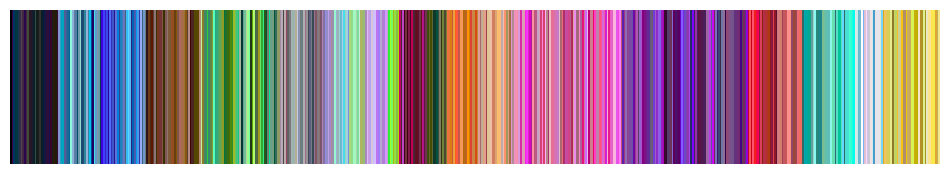

In [ ]:
# Sort the dataframe by 'colour_name'
sorted_df = merged_df.sort_values(by='colour_name').reset_index(drop=True)

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 2))

# Iterate over rows in the sorted dataframe
for i, row in sorted_df.iterrows():
    # Create a rectangle patch with the color
    rect = patches.Rectangle((i, 0), 1, 1, linewidth=1, edgecolor='none', facecolor=(row['r']/255, row['g']/255, row['b']/255))
    ax.add_patch(rect)

# Set limits and remove axes
ax.set_xlim(0, len(sorted_df))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

The most frequent colour name is: purple with a count of 80
The least frequent colour name is: yellow_green with a count of 1


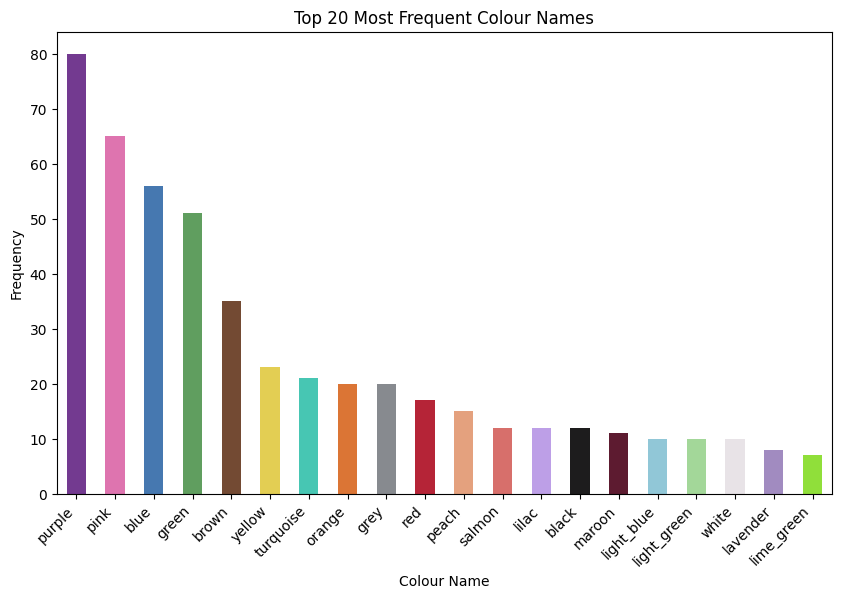

In [ ]:
import matplotlib.pyplot as plt

# Calculate the frequency of each colour name
colour_counts = modal_colour_names_62['colour_name'].value_counts()

# Get the most frequent and least frequent colour names and their counts
most_frequent = colour_counts.idxmax()
least_frequent = colour_counts.idxmin()

most_frequent_count = colour_counts.max()
least_frequent_count = colour_counts.min()

print(f"The most frequent colour name is: {most_frequent} with a count of {most_frequent_count}")
print(f"The least frequent colour name is: {least_frequent} with a count of {least_frequent_count}")

# Get the top 20 most frequent colour names
top_k_colours = colour_counts.head(20)

# Map the colour names to their corresponding RGB values
colour_map = {row['colour_name']: (row['r']/255, row['g']/255, row['b']/255)
              for _, row in rgb_centroids_62.iterrows()}

# Apply the RGB colors to the bars
bar_colors = [colour_map[name] for name in top_k_colours.index]

# Plot the top 20 most frequent colour names with bars colored by their RGB values
plt.figure(figsize=(10, 6))
top_k_colours.plot(kind='bar', color=bar_colors)
plt.title('Top 20 Most Frequent Colour Names')
plt.xlabel('Colour Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


The most frequent colour name is: purple with a count of 81
The least frequent colour name is: lime_green with a count of 7


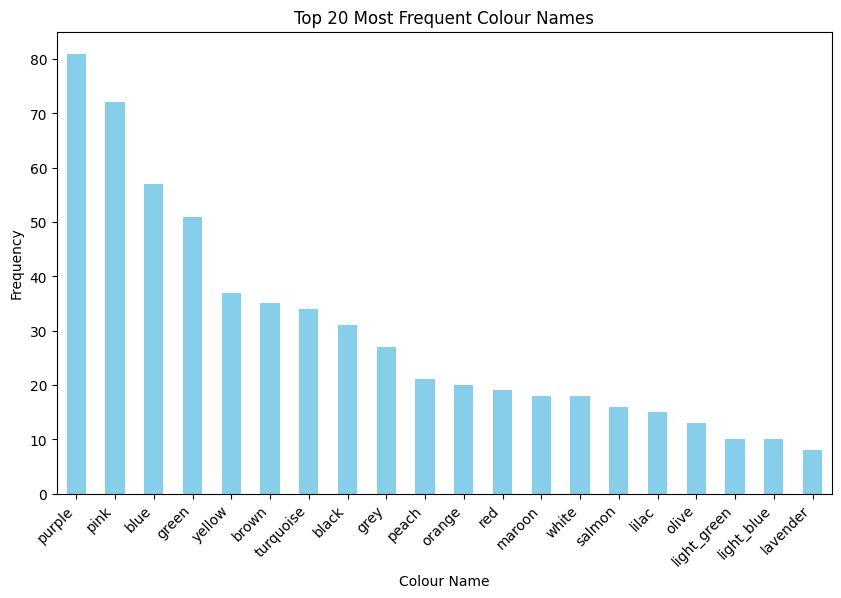

In [ ]:
_# Calculate the frequency of each colour name
colour_counts = modal_colour_names['colour_name'].value_counts()

# Get the most and least frequent colour names and their counts
most_frequent = colour_counts.idxmax()
least_frequent = colour_counts.idxmin()

most_frequent_count = colour_counts.max()
least_frequent_count = colour_counts.min()

print(f"The most frequent colour name is: {most_frequent} with a count of {most_frequent_count}")
print(f"The least frequent colour name is: {least_frequent} with a count of {least_frequent_count}")
# Get the top 10 most frequent colour names
top_k_colours = colour_counts.head(20)

# Plot the top 10 most frequent colour names
plt.figure(figsize=(10, 6))
top_k_colours.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Colour Names')
plt.xlabel('Colour Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
def visualize_all_centroids(title, df, n_cols=8):
    """
    Visualizes all centroid colors in the DataFrame and labels them with their color names.

    Args:
        df (DataFrame): DataFrame containing 'colour_name', 'l', 'u', 'v' columns.
        n_cols (int): Number of columns in the grid. Adjust based on preference.

    Returns:
        None: Displays a grid of color patches with labels.
    """
    # Determine number of rows needed based on the number of colors and columns
    n_rows = int(np.ceil(len(df) / n_cols))

    # Create a figure and set of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()  # Flatten to make it easier to iterate over

    # Add a title to the figure
    fig.suptitle(title, fontsize=16)

    for i, (index, row) in enumerate(df.iterrows()):
        # Extract the L, U, V values
        l, u, v = row['centroid_l'], row['centroid_u'], row['centroid_v']

        # Convert LUV to RGB
        luv_array = np.array([[[l, u, v]]])
        rgb_array = luv2rgb(luv_array).reshape(1, 1, 3)

        # Plot the color
        axes[i].imshow(rgb_array)
        axes[i].set_title(row['colour_name'], fontsize=10)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

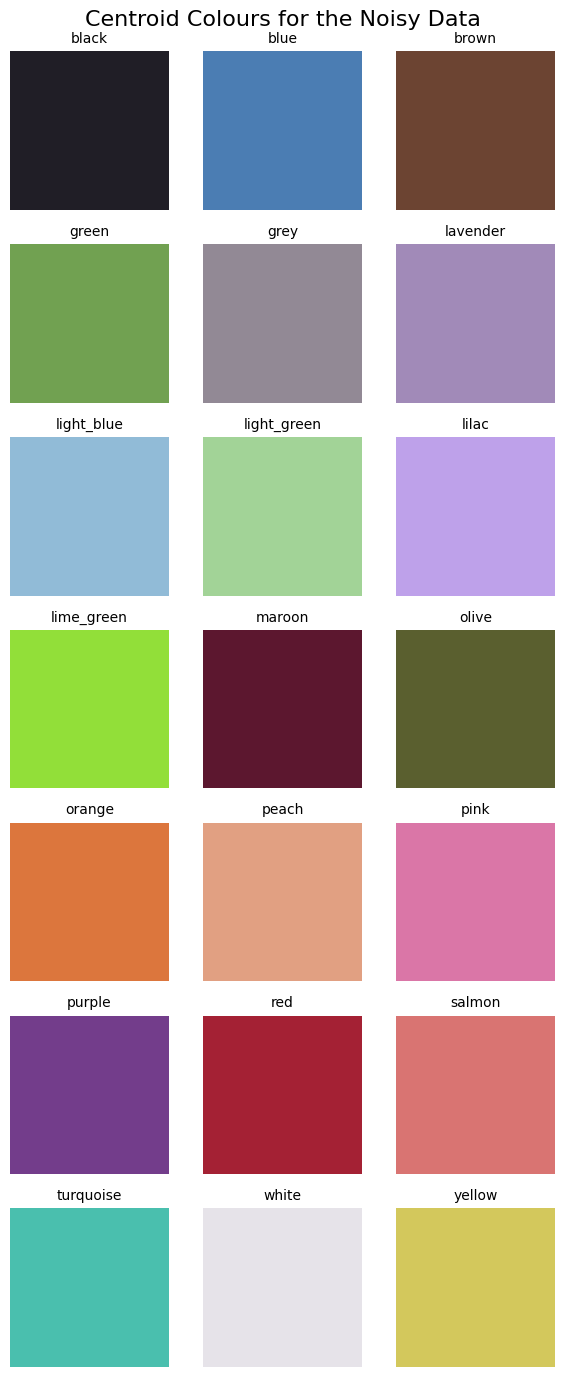

In [ ]:
visualize_all_centroids('Centroid Colours for the Noisy Data', centroids2_noisy, n_cols=3)

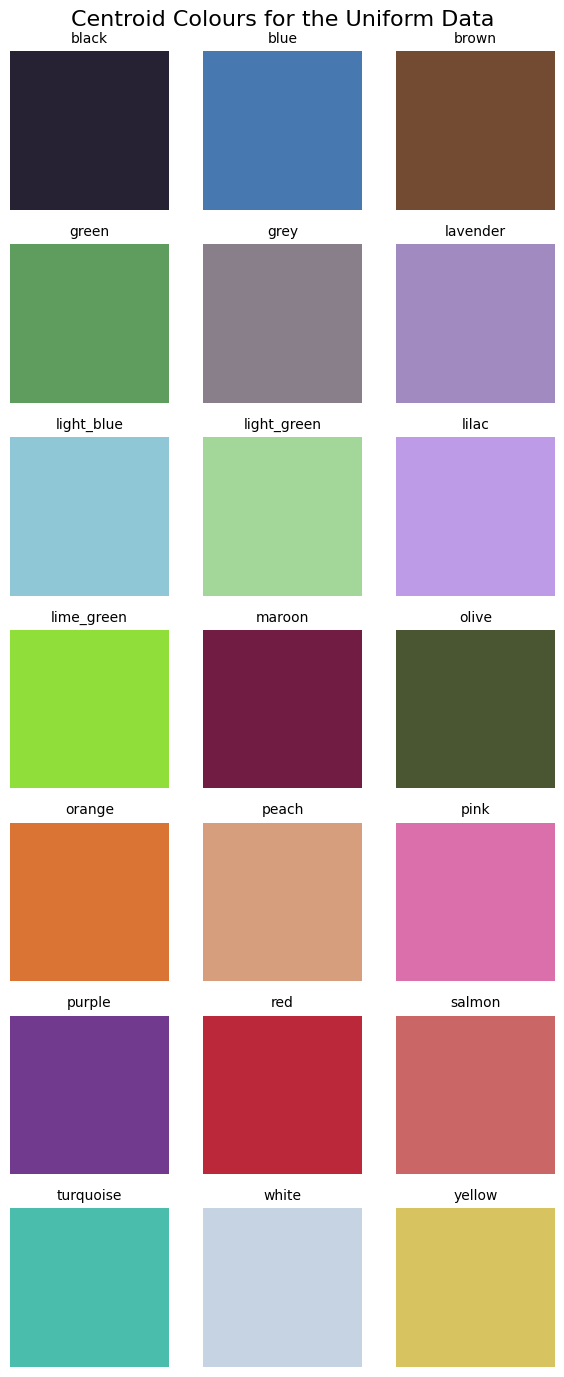

In [ ]:
visualize_all_centroids('Centroid Colours for the Uniform Data', centroids2, n_cols=3)

The dots are the wrong colours but it's cool that you can see the uniform structure in a sort of spiral in both datasets.

In [ ]:
import plotly.express as px

def visualize_3d_samples_plotly(df):
    """
    Visualizes all samples in 3D space using L, U, V coordinates with Plotly.

    Args:
        df (DataFrame): DataFrame containing 'l', 'u', 'v', and 'colour_name' columns.

    Returns:
        None: Displays an interactive 3D scatter plot of the samples.
    """
    fig = px.scatter_3d(df, x='l', y='u', z='v',
                        color='colour_name', labels={'l': 'L*', 'u': 'U*', 'v': 'V*'},
                        title='3D Visualization of All Samples in CIELUV Space')

    fig.update_traces(marker=dict(size=3))
    fig.show()

# Example usage
visualize_3d_samples_plotly(oversampled_data)


In [ ]:
visualize_3d_samples_plotly(modal_colour_names_21)


In [ ]:
visualize_3d_samples_plotly(noisy_oversampled_data)

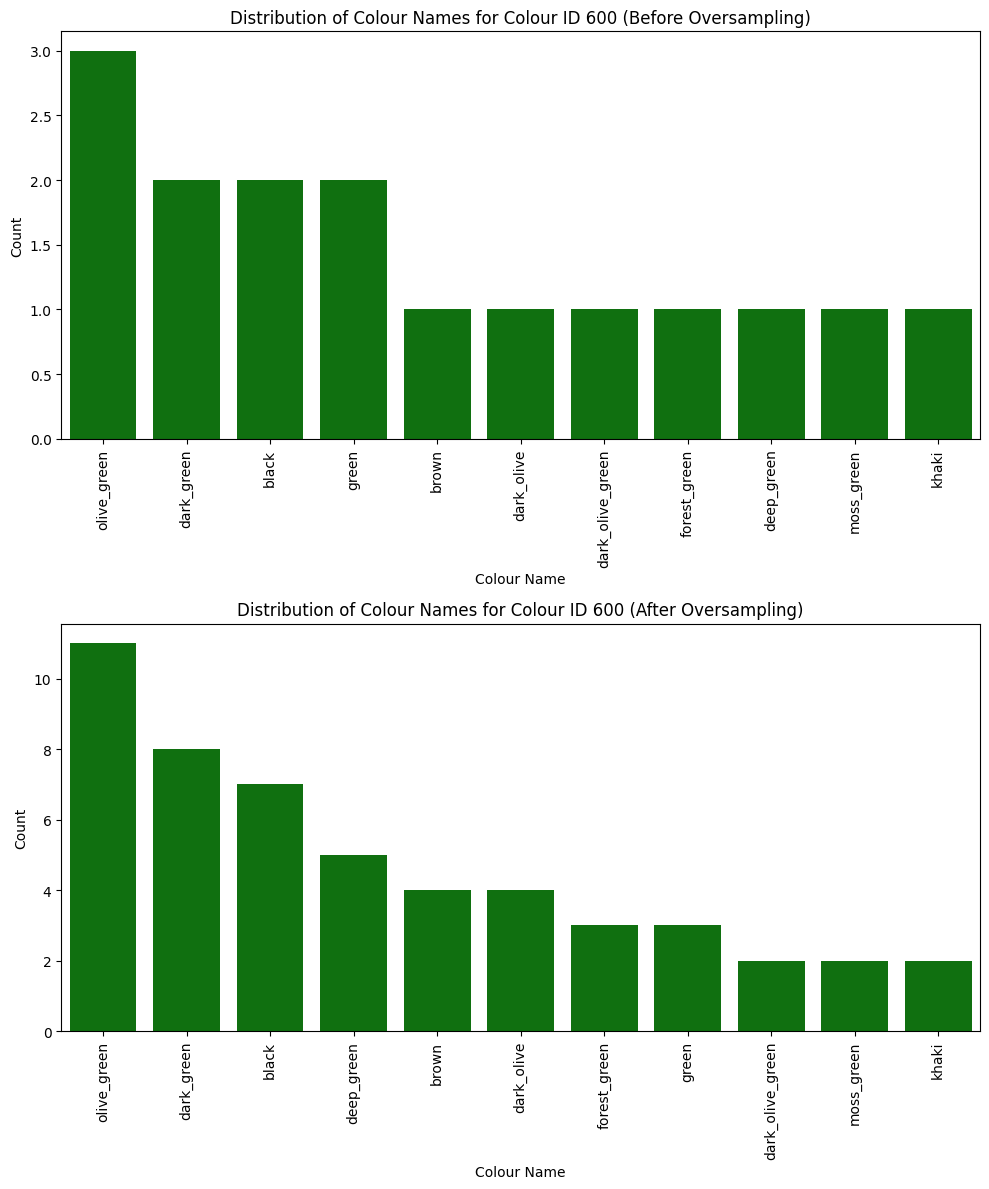

In [ ]:
# Extract the subset for 'colour_id' 600 before oversampling
subset_before = og_clean_data[og_clean_data['colour_id'] == 600]

# Extract the subset for 'colour_id' 600 after oversampling
subset_after = clean_data_resampled[clean_data_resampled['colour_id'] == 600]

# Plot the distribution of 'colour_name' for 'colour_id' 600 before oversampling
plt.figure(figsize=(10, 12))  # Adjust the figure size as needed
plt.subplot(2, 1, 1)
sns.countplot(data=subset_before, x='colour_name', order=subset_before['colour_name'].value_counts().index, color='green')
plt.title('Distribution of Colour Names for Colour ID 600 (Before Oversampling)')
plt.xticks(rotation=90)
plt.xlabel('Colour Name')
plt.ylabel('Count')

# Plot the distribution of 'colour_name' for 'colour_id' 600 after oversampling
plt.subplot(2, 1, 2)
sns.countplot(data=subset_after, x='colour_name', order=subset_after['colour_name'].value_counts().index, color='green')
plt.title('Distribution of Colour Names for Colour ID 600 (After Oversampling)')
plt.xticks(rotation=90)
plt.xlabel('Colour Name')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
